# Competitive Pokemon Analysis

Competitive Pokemon is a game where players construct teams of pokemon with moves, natures, items, etc to battle other live players. In this turn-by-turn game, the objective is to make all (typically 6) of your opponents pokemon faint. Not all Pokemon are equal for this purpose, so based on the usage statistics of the pokemon in competitive play, they are split into various tiers. A player may use a Pokemon to compete in a particular tier if the pokemon is in that tier or below. Historically, usage of various pokemon by players has changed overtime with the introduction of new pokemon, moves, abilities, and mechanics. So, Pokemon are constantly shifted between tiers to maintain balance. You can learn move about competitive pokemon here: https://www.smogon.com/dp/articles/intro_comp_pokemon

In this analysis, we will attempt to classify pokemon into the competitive 6v6 tiers based on the properties of the Pokemon themselves. This classification task is extremely difficult to do accurately, even for someone who is well versed in competitive Pokemon.

## Table of Contents
* [Preliminary Data Processing](#data-processing)
    * [Importing and Formatting](#initial)
    * [Evolutionary Stage and Alternate Forms Feature](#stage-feature)
    * [Alternate Forms Feature](#forms-feature)
    * [Tier Processing](#tier-process)
    * [Moves Corrections](#move-correct)
    
* [Exploratory Data Analysis](#analysis)
    * [Distribution of Tiers](#tier-distribution)
    * [Pokemon Offensive/Defensive Stats](#poke-stats)
    * [Types](#types)
    * [Moves](#moves)
    * [Abilities](#abilities)
    * [Evolutionary Stage](#stage)
    * [Alternate Forms](#forms)
    * [Anomaly Analysis](#anomaly)

* [Modelling](#modelling)
    * [Feature Space Reduction](#feature-reduce)
    * [Encoding Data](#encoding)
    * [Exploratory Modelling/ Feature Selection](#em)
    * [Model Selection](#model-selection)
    * [Model Tuning](#model-tuning)
    
* [Summary and Conclusion](#conclusion)


## Preliminary Data Processing <a class="anchor" id="data-processing"></a>

### Importing and Formatting: <a class="anchor" id="initial"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('pokemon-data.csv', delimiter=';')
mdf = pd.read_csv('move-data.csv', delimiter=';')

print('Number of pokemon: ', len(df))
df.sample()

Number of pokemon:  918


,Name,Types,Abilities,Tier,HP,Attack,Defense,Special Attack,Special Defense,Speed,Next Evolution(s),Moves
492,Mesprit,['Psychic'],['Levitate'],PU,80,105,105,105,105,80,[],"['Healing Wish', 'Natural Gift', 'Copycat', 'R..."


In [3]:
print('Number of moves: ', len(mdf))
mdf.sample()

Number of moves:  728


,Index,Name,Type,Category,Contest,PP,Power,Accuracy,Generation
227,228,Pursuit,Dark,Physical,Clever,20,40,100,2


In [4]:
#Preliminary Processing:
mdf.columns = ['index', 'name', 'type', 'category', 'contest', 'pp', 'power', 'accuracy', 'generation']
mdf.set_index('index')
mdf['power'].replace('None', 0, inplace=True)
mdf['accuracy'].replace('None', 100, inplace=True)
mdf['power'] = pd.to_numeric(mdf['power'])
mdf['accuracy'] = pd.to_numeric(mdf['accuracy'])
mdf.sample()

df.columns = ['name', 'types', 'abilities', 'tier', 'hp', 'atk', 'def', 'spa', 'spd', 'spe', 'next_evos','moves']

#turn the lists into actual lists
df['next_evos'] = df.apply(lambda x: eval(x.next_evos), axis=1)
df['types'] = df.apply(lambda x: eval(x.types), axis=1)
df['abilities'] = df.apply(lambda x: eval(x.abilities), axis=1)
df['moves'] = df.apply(lambda x: eval(x.moves), axis=1)

df.set_index('name', inplace=True)

## Data Correction

After inspecting the moves of each pokemon, there is an interest a couple interesting quirks in how the data was stored. First:

In [5]:
weird_moves = set()

for ind, row in df.iterrows():
    for move in row.moves:
        if "'" in move:
            weird_moves.add(move)
            
print(weird_moves)

{"King's Shield", "Power'Up Punch", "Forest's Curse", "Will'O'Wisp", "Soft'Boiled", "Lock'On", "Trick'or'Treat", "Nature's Madness", "X'Scissor", "Self'Destruct", "U'turn", "Mud'Slap", "Freeze'Dry", "Baby'Doll Eyes", "Double'Edge", "Wake'Up Slap", "Topsy'Turvy", "Multi'Attack", "Land's Wrath"}


Many of these moves, such as U-turn, should have a dash instead of an apostrophe (according to the moves dataset). Upon closer inspection, it's clear that the only moves that should have an apostrophe are those whose words end with an apostrophe-s. Let's make this correction.

In [6]:
weird_moves.remove("King's Shield")
weird_moves.remove("Forest's Curse")
weird_moves.remove("Land's Wrath")
weird_moves.remove("Nature's Madness")

df['moves'] = df.apply(
    lambda x: [move if move not in weird_moves else move.replace("'", "-")
                  for move in x.moves],
    axis = 1
)

removal_check_set = set()
for ind, row in df.iterrows():
    for move in row.moves:
        if "'" in move:
            removal_check_set.add(move)

removal_check_set

{"Forest's Curse", "King's Shield", "Land's Wrath", "Nature's Madness"}

Second, you'll notice that many move lists have duplicates of the same move. Veekun (the website from which this data was scraped) has different tables for lists of moves depending on how the move can be learned (by level up, egg moves, TM/HM, special events, etc), which results in duplicates. Let's solve this by turning the movepools into sets instead of lists.


In [7]:
df['moves'] = df.apply(lambda x: set(x.moves), axis=1)

The moves dataframe contains moves that are unlearnable by pokemon. These include moves like Struggle (which is a move pokemon use when they have no more pp in their normal moveset) and Z-moves (moves that are activated by a Z-crystal). These moves are characterized by having only 1 PP (which denotes the number of times a pokemon can use the move). Let's remove these.

In [8]:
mdf = mdf[(mdf.pp != 1) | (mdf.name == 'Sketch')]

Some inspection revealed that there are 9 moves which should be learned by pokemon that are not included in any move lists: V-create, Happy Hour, Celebrate, Hold Hands, Hold Back, Thousand Arrows, Thousand Waves, Core Enforcer, and Plasma Fists. Some research revealed that these most of these moves are either special event moves, or are Ultra Soon/Ultra Moon exclusives, and so for some reason are not included on movelists on Veekun. The exceptions are Zygarde's signature moves, Thousand Arrows and Thousand Waves, which are also not on Veekun (possibly because they can be only learned upon the creation of the Zygarde Cube).

Of these moves, Happy Hour, Celebrate, Hold Hands have no effect in competitive battle, so we will remove them. Plasma Fists is only learned by Zeraora, which is unreleased, so it will be removed as well. The rest we will correct manually.

In [9]:
df.loc['Victini', 'moves'].add('V-create')
df.loc['Rayquaza', 'moves'].add('V-create') #technically should have Mega Rayquaza as well, but it's in AG
df.loc['Celebi', 'moves'].add('Hold Back')

for pok in ['Zygarde', 'Zygarde-10%', 'Zygarde-Complete']:
    df.loc[pok, 'moves'].add('Thousand Arrows')
    df.loc[pok, 'moves'].add('Thousand Waves')
    df.loc[pok, 'moves'].add('Core Enforcer')

for pok in ['Celebi', 'Serperior', 'Emboar', 'Samurott']: #'Mareep', 'Beldum', 'Munchlax' are all LC 
    df.loc[pok, 'moves'].add('Hold Back')

mdf = mdf[(mdf.name != 'Happy Hour') & (mdf.name != 'Celebrate') & (mdf.name != 'Hold Hands') & (mdf.name != 'Plasma Fists')]

We must be cautious analyzing the moves as there may be more inconsistencies. In particular, other event moves may have been missed that some pokemon learn via level-up.

### Evolutionary Stage Feature: <a class="anchor" id="stage-feature"></a>

The next evolution information is not immediately useful; however, we can determine how far a pokemon is in its evolutionary chain. Notice that a pokemon can have one, two, or three evolutions in its chain. A pokemon that is in its final form after one evolution is not necessarily weaker or stronger than another after two evolutions. For each pokemon, let's store it's "progress" in its evolution as a number between 0 to 1.

In [10]:
def stage_in_evo(n):
    # returns number of evolutions before it
    #print(df[df['name'] == n]['name'])
    bool_arr = df.apply(lambda x: n in x['next_evos'] and (n+'-') not in x['next_evos'], axis=1) #gets index of previous evolution
    if ('-' in n and n.split('-')[0] in df.index and n != 'Porygon-Z'): #'-Mega' in n or  
        #megas and alternate forms should have same evolutionary stage as their base
        return stage_in_evo(n.split('-')[0])
    elif not any(bool_arr):
        return 1 # if there's nothing before it, it's the first
    else:
        return 1 + stage_in_evo(df.index[bool_arr][0])

def num_evos(n):
    if n not in df.index: #checks to ensure valid pokemon
        return n
    
    next_evos = df.loc[n, 'next_evos']
    if len(next_evos) > 0: #existence of next_evo
        if n in next_evos[0]: # if "next evo" is an alternate form
            return df.loc[n, 'stage'] #accounting for alternate forms
        else:
            return num_evos(next_evos[0])
    elif '-Mega' in n or (n.split('-')[0] in df.index and n != 'Porygon-Z'): 
        #this is checking if there is a pokemon with the same root name (e.g. Shaymin vs Shaymin-Sky)
        return df.loc[n.split('-')[0], 'stage']
    else:
        return df.loc[n, 'stage']

In [11]:
df['stage'] = df.apply(lambda x: stage_in_evo(x.name), axis=1)

In [12]:
df['num_evos'] = df.apply(lambda x: num_evos(x.name), axis=1)

In [13]:
df['evo_progress'] = df['stage']/df['num_evos'] 
del df['stage']
del df['num_evos']

In [14]:
df[(df.index == 'Scyther') |
   (df.index == 'Scizor') | 
   (df.index == 'Porygon') |
   (df.index == 'Porygon2') |
   (df.index == 'Porygon-Z')] #test

,types,abilities,tier,hp,atk,def,spa,spd,spe,next_evos,moves,evo_progress
name,,,,,,,,,,,,
Porygon,[Normal],"[Analytic, Download, Trace]",NaN,65,60,70,85,75,40,[Porygon2],"{Thunderbolt, Psyshock, Giga Impact, Discharge...",1.000000
Porygon-Z,[Normal],"[Adaptability, Analytic, Download]",UUBL,85,80,70,135,75,90,[],"{Thunderbolt, Psyshock, Giga Impact, Discharge...",1.000000
Porygon2,[Normal],"[Analytic, Download, Trace]",RU,85,80,90,105,95,60,[Porygon-Z],"{Thunderbolt, Psyshock, Giga Impact, Discharge...",0.666667
Scizor,"[Bug, Steel]","[Light Metal, Swarm, Technician]",UU,70,130,100,55,80,65,[],"{Fling, Struggle Bug, Giga Impact, Acrobatics,...",1.000000
Scyther,"[Bug, Flying]","[Steadfast, Swarm, Technician]",NU,70,110,80,55,80,105,[Scizor],"{Struggle Bug, Giga Impact, Return, Vacuum Wav...",0.500000


### Alternate Forms Feature: <a class="anchor" id="forms-feature"></a>

Alternate forms, unlike evolutions, are commonly attained using items or other means. They are typically equal to or more powerful than their base-counterparts. Let's create two indicator features: one for if a pokemon is a mega-evolution, and another for if a pokemon is an alternate form. Although alolan forms are technically alternate forms, they are really different pokemon with similar stats and movepools. For the purpose of this analysis, alolan forms will be considered seperate pokemon.

In [15]:
df['mega'] = df.apply(lambda x: 1 if '-Mega' in x.name else 0, axis=1)
df['alt_form'] = df.apply(lambda x: 1 if ('-' in x.name and 
                                                x.mega == 0 and 
                                                '-Alola' not in x.name and 
                                                x.name.split('-')[0] in df.index and
                                                x.name != 'Porygon-Z')
                                            else 0,
                                            axis = 1)
df[(df.index == 'Landorus-Therian') | 
   (df.index == 'Landorus') | 
   (df.index == 'Shaymin-Sky') | 
   (df.index == 'Blaziken-Mega') | 
   (df.index == 'Diglett-Alola') | 
   (df.index == 'Porygon2') |
   (df.index == 'Porygon-Z')] #test

,types,abilities,tier,hp,atk,def,spa,spd,spe,next_evos,moves,evo_progress,mega,alt_form
name,,,,,,,,,,,,,,
Blaziken-Mega,"[Fire, Fighting]",[Speed Boost],Uber,80,160,80,130,80,100,[],"{Bounce, Rock Climb, Acrobatics, Return, Vacuu...",1.000000,1,0
Diglett-Alola,"[Ground, Steel]","[Sand Force, Sand Veil, Tangling Hair]",LC,10,55,30,35,45,90,[Dugtrio-Alola],"{Return, Attract, Earth Power, Bulldoze, Mud-S...",0.500000,0,0
Landorus,"[Flying, Ground]","[Sand Force, Sheer Force]",Uber,89,125,90,115,80,101,[Landorus-Therian],"{Fling, Block, Giga Impact, Return, Swords Dan...",1.000000,0,0
Landorus-Therian,"[Flying, Ground]",[Intimidate],OU,89,145,90,105,80,91,[],"{Fling, Block, Giga Impact, Return, Swords Dan...",1.000000,0,1
Porygon-Z,[Normal],"[Adaptability, Analytic, Download]",UUBL,85,80,70,135,75,90,[],"{Thunderbolt, Psyshock, Giga Impact, Discharge...",1.000000,0,0
Porygon2,[Normal],"[Analytic, Download, Trace]",RU,85,80,90,105,95,60,[Porygon-Z],"{Thunderbolt, Psyshock, Giga Impact, Discharge...",0.666667,0,0
Shaymin-Sky,"[Flying, Grass]",[Serene Grace],Uber,100,103,75,120,75,127,[],"{Giga Impact, Return, Last Resort, Swords Danc...",1.000000,0,1


### Tier Processing: <a class="anchor" id="tier-process"></a>

As of generation 7, there are 8 playable tiers. From strongest to weakest: Anything Goes (AG), Uber, Overused (OU), Underused (UU), Rarelyused (RU), Neverused (NU), Partiallyused (PU) and Little Cup (LC). There are also unplayable tiers called borderline tiers, suffixed by BL. These serve as banlists for their respective tiers (so these pokemon can only be used in higher tiers). For the purpose of this analysis, we will classify BL pokemon as the tier above.

We will not consider the Little Cup (LC) format, as they are not defined by usage statistics (it involves pokemon that are not evolved but are capable of evolution and can be obtained in the traditional games at level 5). We will also discard the AG tier, as it was created solely for Mega Rayquaza. Both Pokemon that belong to no tier because they are uncompetitive and pokemon in the Limbo tier becuase they are unreleased will not be considererd.

Let's make these changes. Also, we shall number the tiers to make plotting easier (lower number => better tier)

In [16]:
df.loc[df.tier == 'OUBL','tier'] = 'Uber'
df.loc[df.tier == 'UUBL','tier'] = 'OU'
df.loc[df.tier == 'RUBL','tier'] = 'UU'
df.loc[df.tier == 'NUBL','tier'] = 'RU'
df.loc[df.tier == 'PUBL','tier'] = 'NU'
df = df[df['tier'].isin(['Uber', 'OU', 'UU', 'NU', 'RU', 'PU'])]

In [17]:
tiers = ['Uber', 'OU', 'UU', 'RU', 'NU', 'PU']
tier_mapping = {tier:num for num, tier in enumerate(tiers)}
df['tier_num'] = df.apply(lambda x: tier_mapping[x.tier], axis=1)
tier_mapping

{'Uber': 0, 'OU': 1, 'UU': 2, 'RU': 3, 'NU': 4, 'PU': 5}

### Miscallaneous: <a class="anchor" id="move-correct"></a>

A large movepool is considered an asset in competitive pokemon. For many pokemon, a large movepool makes it hard to predict what mvoeset your opponent is running. Let's create another feature describing the number of moves in the movepool to use in analysis.

In [18]:
df['num_moves'] = df.apply(lambda x: len(x.moves), axis=1)

The base stat total is a common metric players use to assess a Pokemon's overall strength, so let's create a column for this.

In [19]:
df['bst'] = df['hp'] + df['atk'] + df['def'] + df['spa'] + df['spd'] + df['spe']
#df = df[['name', 'types', 'abilities', 'tier', 'hp', 'atk', 'def', 'spa', 'spd', 'spe', 'bst', 'next_evos','moves']]

In game, return has a base power of 102 when friendship is maximized and frusturation has a base power of 102 when friendship is minimized. In competitive, friendship can be set, so we will set the strength of frusturation and return to 102.

In [20]:
mdf.loc['Frusuration', 'power'] = 102
mdf.loc['Return', 'power'] = 102

## Exploratory Data Analysis <a class="anchor" id="analysis"></a>

### Distribution of Tiers: <a class="anchor" id="tier-distribution"></a>

Let's explore some of the relationships in this data. First, the distribution of the classes:

Total number of Pokemon:  552


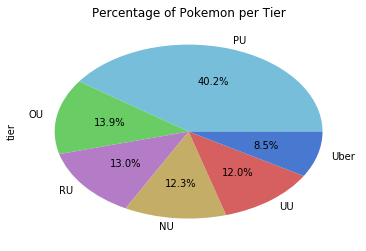

In [21]:
c = sns.color_palette('muted')
c = [c[5], c[1], c[3], c[4], c[2], c[0]]

ax = df.tier.value_counts().plot(kind='pie', autopct='%1.1f%%', colors=c, title='Percentage of Pokemon per Tier')
print('Total number of Pokemon: ', len(df))

All the upper tiers are similar in size by design, but the PU tier is a dump of all the least used pokemon. We must account for this later. Let's create a dictionary with the sizes of each tier for reference:

In [22]:
tier_size = { t:len(df[df.tier == t]) for t in tiers}
tier_size

{'Uber': 47, 'OU': 77, 'UU': 66, 'RU': 72, 'NU': 68, 'PU': 222}

### Pokemon Offensive/Defensive Stats <a class="anchor" id="poke-stats"></a>

Let's examine how the the average stats compare for each tier:

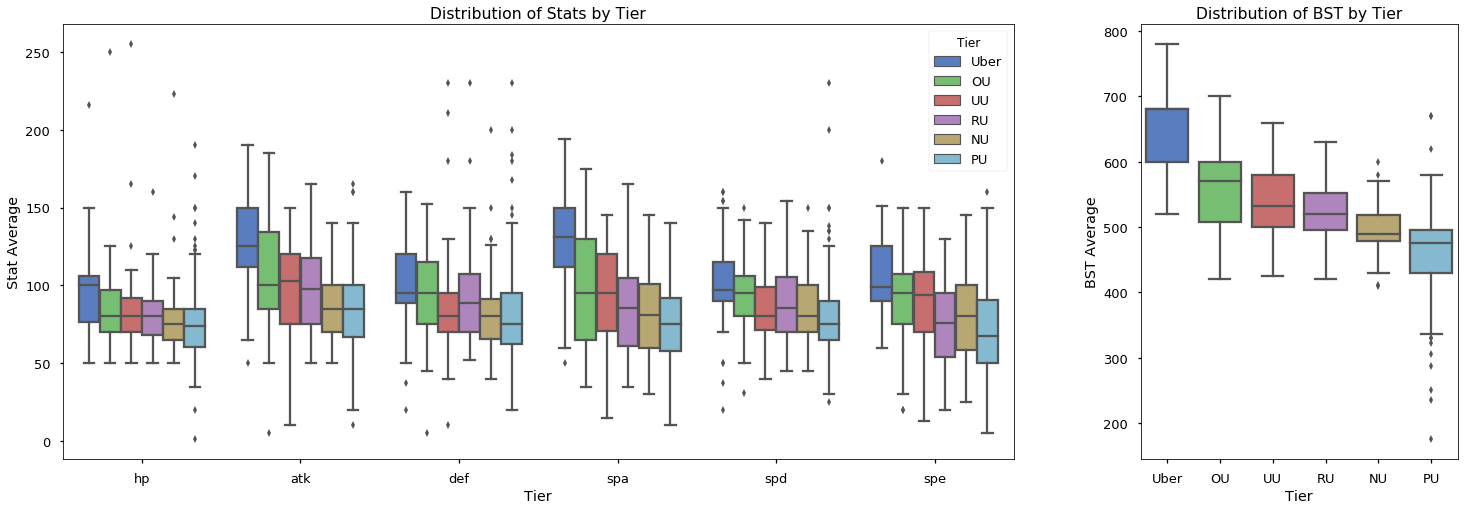

In [23]:
stats_df = df[['tier', 'tier_num', 'hp', 'atk', 'def', 'spa', 'spd', 'spe']]
stats_df = stats_df.reset_index()
stats_df = stats_df.melt(id_vars=['name', 'tier', 'tier_num']).sort_values('tier_num', ascending=True)
stats_df.columns = ('name', 'Tier', 'tier_num', 'Stat', 'Value')
#stats_df.Value = pd.to_numeric(stats_df.Value)

sns.set_context('talk')
fig, ax = plt.subplots(1,2, figsize=(25,8), gridspec_kw = {'width_ratios':[3, 1]})
g = sns.boxplot(data=stats_df, x="Stat", y="Value", order=['hp', 'atk', 'def', 'spa', 'spd', 'spe'],
                hue="Tier", palette="muted", ax=ax[0])
g2 = sns.boxplot(data=df, x='tier', y='bst', order=tiers, palette="muted", ax=ax[1])
#g2=sns.factorplot(x="Tier", y="Average", hue_order=['bst'],hue="Stat", data=temp2,
#                   kind="bar", palette="muted", aspect=1.5,  ax=ax[1])
ax[0].set(xlabel='Tier', ylabel='Stat Average', title='Distribution of Stats by Tier')
ax[1].set(xlabel='Tier', ylabel='BST Average', title='Distribution of BST by Tier')
None;

Note the different scales. As expected, there is a correlation between how the level of the tier and the pokemon's stats. Interestingly, attack and special attack stats tend to become more prominent in the higher tiers, indicating a more offensive playstyle in these tiers. Also, RU seems to have a lower average speed than NU but higher defensive stats than UU, indicating a particularly defensive playstyle in this tier. 

These trends are not mostly not significant, as the confidence intervals for the BST and all the stats is quite high. This will make classification using stats more difficult.

However, evaluating just the average of stats is unfair: most pokemon are strong in one way or another that distinguishes them. Most viable pokemon have two strong stats. For example, offensive sweepers have a high special/attack and speed, bulky offensive pokemon have high special/attack and HP, defensive pokemon have a high defense and HP. Let's graph pokemon by the average of their x strongest stats, for x = 1 to 6.

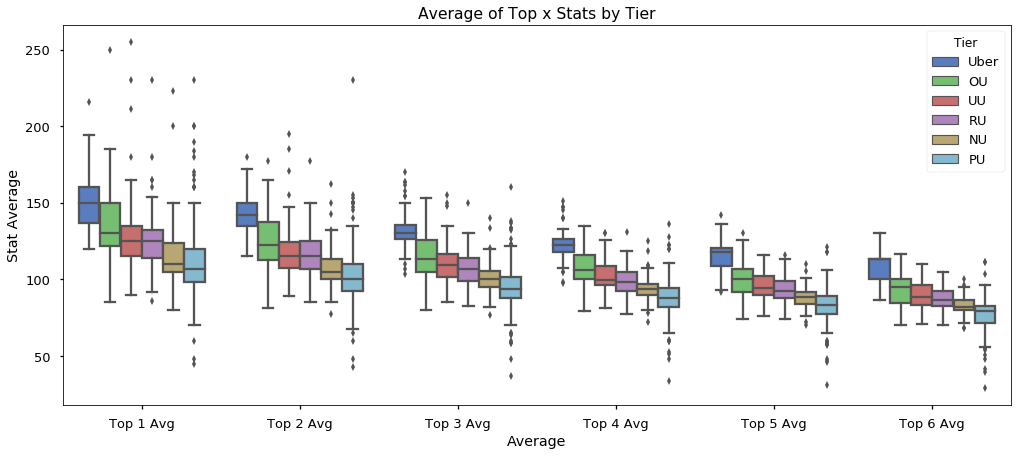

In [24]:
stats_df2 = df.loc[:, ['tier', 'hp', 'atk', 'def', 'spa', 'spd', 'spe']].reset_index().set_index(['name','tier'])
aggregates = {('Top {} Avg'.format(v),(lambda x, v=v: np.mean(np.sort(x)[::-1][:v]))) for v in range(1, 7)} 
stats_df2 = stats_df2.stack().groupby(['name','tier']).agg(aggregates).stack().reset_index()
stats_df2.columns = ['Name', 'Tier', 'Average', 'Stat Average']

plt.subplots(figsize=(17,7))
sns.boxplot(data=stats_df2.sort_values('Average'), hue='Tier', y='Stat Average', x='Average', 
            hue_order=tiers, palette='muted').set_title('Average of Top x Stats by Tier')
None;

Interestingly, our hypothesis was incorrect. Considering the top stats actually gave us more variance than simply averaging all of them. The distinction between the different tiers also grows more clear as we consider more stats. 

Let's look at the univariate and bivariate distirbutions of all the stats themselves.

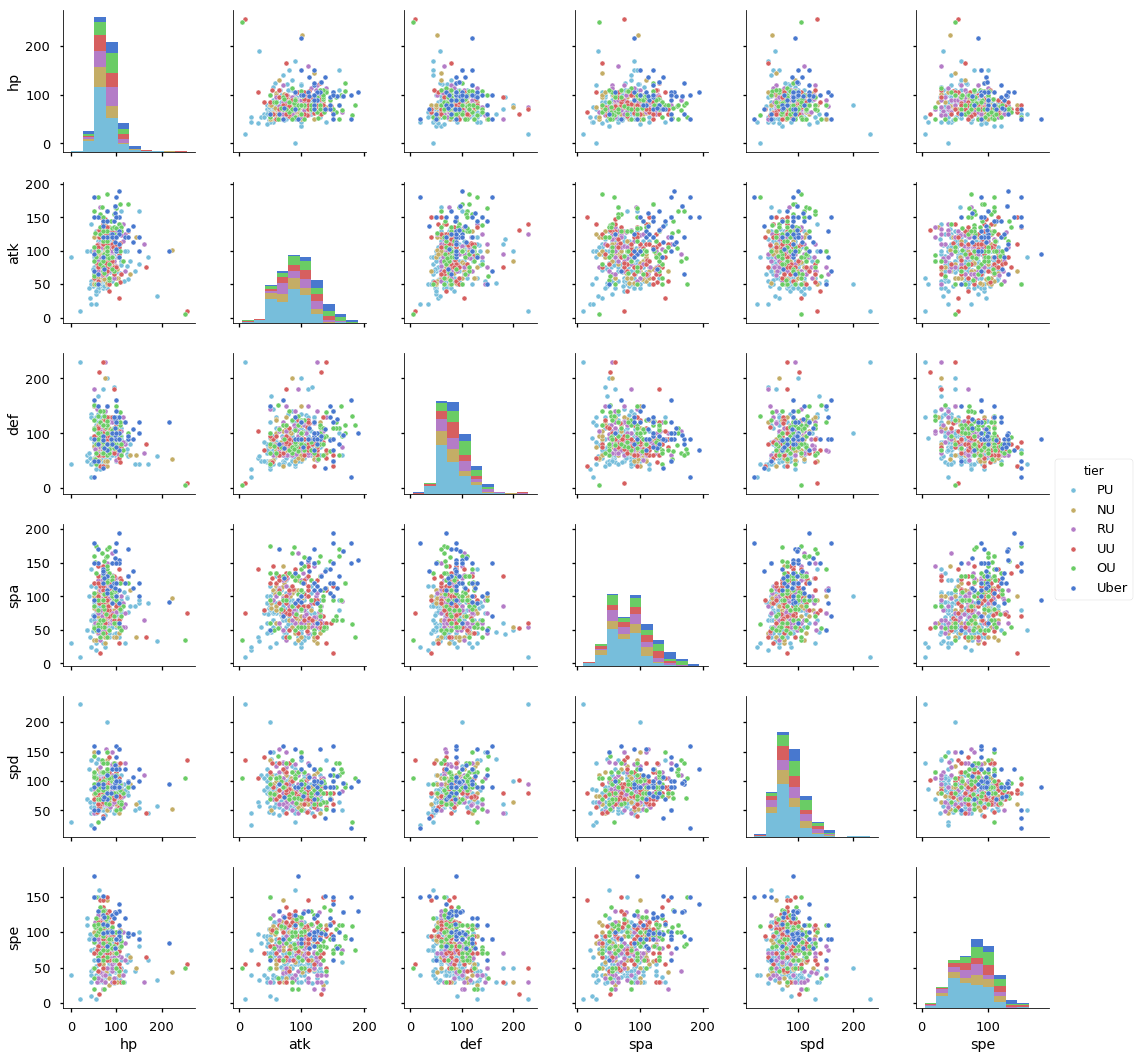

In [25]:
stats_df = df[['tier', 'hp', 'atk', 'def', 'spa', 'spd', 'spe']] #'tier_num', , 'bst'
sns.pairplot(stats_df, hue='tier', hue_order=list(reversed(tiers)), plot_kws={'s':25},
               palette=list(reversed(sns.color_palette('muted'))))

None of the stats are normally distributed, which is important to note for modelling. All the stats seem to be skewed in some way, and special attack appears to be bimodal for unknown reasons. There are no particularly interesting bivariate distributions between various stats. 

In competitive pokemon, there are various user-made classifications of pokemon that describe the distribution of their stats and typical movesets. For example, a pokemon with high special/attack and speed stats is typically a sweeper; high HP and defense(s) is a wall; high special/attack and reasonable defenses with low speed is a tank; and etc.

All the tiers tend to have all the different classifications, so it is unlikely that we will be able to cluster based on stats alone. Let's use Principal Component Analysis to plot all the stats onto a 2D scatter plot to see if this is true.

Variation per principal component: [0.28036344 0.2397493  0.1916674  0.13833584 0.09038911 0.05949491]


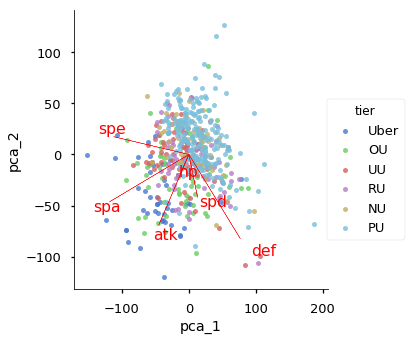

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6)
pca_result = pca.fit_transform(df[['hp', 'atk', 'def', 'spa', 'spd', 'spe']].values)
pca_df = df.copy()
pca_df = pca_df[['tier']]
pca_df['pca_1'] = pca_result[:,0]
pca_df['pca_2'] = pca_result[:,1] 
pca_df['pca_3'] = pca_result[:,2]
print(f'Variation per principal component: {pca.explained_variance_ratio_}')
sns.lmplot(data = pca_df, x='pca_1', y='pca_2', hue='tier', hue_order=tiers, fit_reg=False, palette='muted', scatter_kws={'s':25})

# below code from https://github.com/teddyroland/python-biplot/blob/master/biplot.py
xs = pca_df['pca_1']
ys = pca_df['pca_2']
xvector = pca.components_[0]
yvector = pca.components_[1]
dat = df[['hp', 'atk', 'def', 'spa', 'spd', 'spe']]

for i in range(len(xvector)):
    # arrows project features (ie columns from csv) as vectors onto PC axes
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='r', width=0.0005, head_width=0.0025)
    plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
             list(dat.columns.values)[i], color='r')
    
#for i in range(len(xs)):
# circles project documents (ie rows from csv) as points onto PC axes
    #plt.plot(xs[i], ys[i], 'bo', markersize=5)
    #plt.text(xs[i]*1.2, ys[i]*1.2, list(dat.index)[i], color='b')

The first two components make up about 52% of the variance; however, as expected, it is hard to distinguish any meaningful relationships. Though there some information, as the weakest tier, PU, dominates the bottom left while the highest tier, Uber, dominates the upper right. Interestingly, the largest outliers lie along the speed, attack, and special attack axis, suggesting that pokemon offensive pokemon tend to lie on the extremes. This likely represents the magnitude of the stats of the pokemon in those tiers moreso than the distributions themselves.

### Types <a class="anchor" id="types"></a>

Moving away from the pokemon stats, let's look at the types. Both Pokemon can have one or two types while moves have one type. A  move of a given type can be super effective (2x damage), effective (1x damage), not very effective (0.5x damage), or ineffective (0x damage) against another type. When a pokemon has two types, this effect can be compounded (ie 4x damage or 0.25x damage). This is summarized in the table below from https://rankedboost.com/pokemon-sun-moon/type-chart/:

<img src="type-chart.jpg">

This means that certain types and type combinations are advantageous defensively and/or offensively. Let's create a heatmap of the overall distribution of type combinations for pokemon, then heatmaps describing the distribution relative to the overall distribution.

[Text(0.5,1,'Frequency of Type Combinations')]

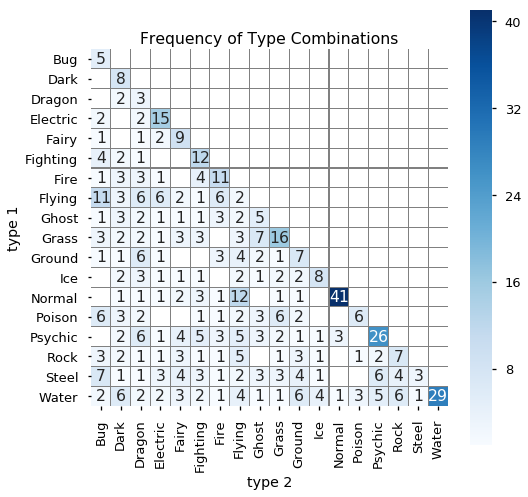

In [27]:
type_set = set()

for ind, row in df.iterrows():
    type_set |= set(row.types) #for use later

type_df_temp = df.copy()
type_df_temp['type 1'] = type_df_temp.apply(lambda x: sorted(x['types'])[0], axis=1)
type_df_temp['type 2'] = type_df_temp.apply(lambda x: sorted(x['types'])[-1], axis=1) #if a pokemon has a single type, type 2 = type 1

type_df = type_df_temp[['type 2', 'type 1']].groupby(['type 2', 'type 1']).size().reset_index()
type_df.columns = ['type 1', 'type 2', 'count']
type_pivoted_df = type_df.pivot('type 1', 'type 2', 'count')

plt.subplots(figsize=(8,8))
sns.heatmap(type_pivoted_df, annot=True, square=True, cmap='Blues', linecolor='grey', linewidths='0.05')
plt.gca().set(title='Frequency of Type Combinations')

This alone is not particularly interesting, except for the fact that purely Normal, Water, and Psychic type pokemon are very common. With a much larger dataset, the frequencies per tier would be interesting, but on this small set with many unique type combinations, the frequencies per tier would not contain much information. Instead, let's look at the overall frequencies of individual types:

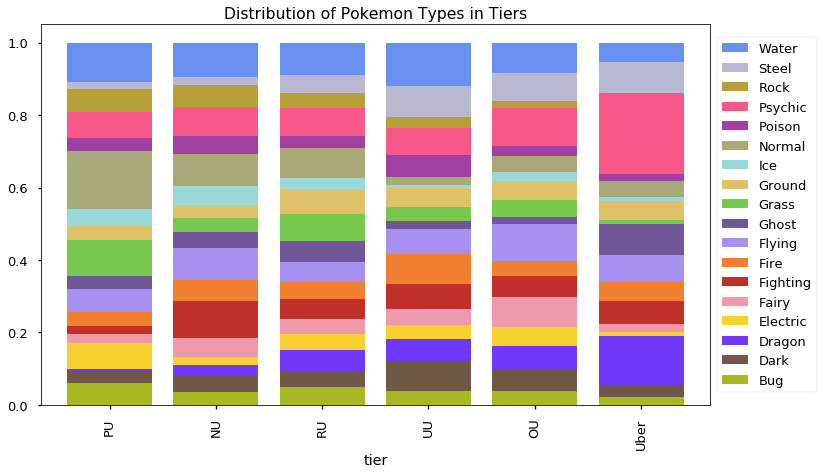

In [28]:
#Get individual counts of type1 and type 2
type1_count = type_df_temp[['tier', 'type 1']].groupby(['tier', 'type 1']).size().reset_index()
type2_count = type_df_temp[['tier', 'type 2']].groupby(['tier', 'type 2']).size().reset_index()
type1_count.columns=['tier', 'type', 'count1']
type2_count.columns=['tier', 'type', 'count2']

#Get overall type frequency per tier
type_count = pd.merge(type1_count, type2_count, on=['tier', 'type'], how='outer')
type_count.fillna(value=0, inplace=True)
type_count['count'] = type_count['count1'] + type_count['count2']
type_count_ind = type_count.set_index(['tier','type'])
type_count['count'] = type_count.apply(lambda x: x['count']/np.sum(type_count_ind.loc[x['tier'], 'count'])
                                      , axis=1) # /np.sum(type_count_ind2.loc[x['tier'], 'count'])

#Format Table and Sort rows
type_count = type_count[['tier','type','count']]
type_count = type_count.set_index(['tier','type']).unstack()['count']
type_count['tier_nums'] = type_count.apply(lambda x: tier_mapping[x.name],axis=1)
type_count = type_count.sort_values(by='tier_nums', ascending=False)
del type_count['tier_nums']

colors = [(104,144,240), (184,184,208), (184,160,56), (248,88,136), 
          (160,64,160), (168,168,120), (152,216,216), (224,192,104), 
          (120,200,80), (112,88,152), (168,144,240), (240,128,48), 
          (192,48,40), (238,153,172), (248,208,48), (112,56,248), 
          (112,88,72), (168,184,32)]
colors = [tuple(i/255.0 for i in c)
               for c in colors]
#Plit
type_count.plot.bar(stacked=True, title='Distribution of Pokemon Types in Tiers', 
                     legend=False, figsize=(12, 7), sort_columns=True, width=0.8,
                    color=reversed(colors))
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), handles=handles[::-1])

The stronger the tier, the more prominent dragon, psychic, and steel types are. The weaker the tier, the more prominent normal grass types are. The distribution of steel, dragon, and grass types can be partly explained by their type advantages: dragon is an effective offensive type, steel is an effective defensive type, and grass is poor at both. However, this distribution is caused by the bias of the game developers. For example, "legendary" pokemon tend to be part dragon or psychic types.

Next, let's take a look at pokemon moves and abilities. An individual pokemon may only have one ability out of one, two, or three options (depending on the pokemon). Similarly, an individual pokemon may have up to four moves in its moveset out of many.

### Moves <a class="anchor" id="moves"></a>

There are certain moves that make otherwise mediocre pokemon powerful, such as the Shell Smash on Cloyster. There are also many exclusive moves that give pokemon an upper hand. Most moves, however, are pretty standard and are learned by a wide range of pokemon. We can do much analysis on moves with their power, types, and etc, but we will focus on which Pokemon learn them and how that impacts what tier they belong to.

Let's first take a look at the distribution of how many pokemon learn particular moves.

In [29]:
mdf.set_index('name', inplace=True)

mdf['uber count'] = 0
mdf['ou count'] = 0
mdf['uu count'] = 0
mdf['ru count'] = 0
mdf['nu count'] = 0
mdf['pu count'] = 0

for ind, row in df.iterrows():
    for move in row.moves:
        mdf.loc[move, row.tier.lower() + ' count'] += 1
        
mdf['count'] = mdf['uber count'] + mdf['ou count'] + mdf['uu count'] + mdf['ru count'] + mdf['nu count'] + mdf['pu count']
#mdf = mdf.reset_index()

[Text(0.5,1,'Frequencies of Moves by the Number of Pokemon that Learn Them')]

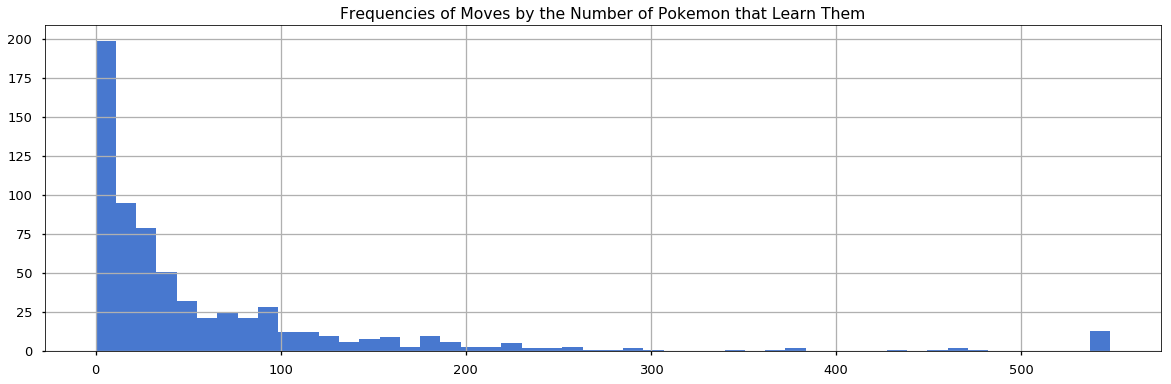

In [30]:
plt.figure(figsize=(20, 6))
mdf['count'].hist(bins=50, color=sns.color_palette('muted')[0])
plt.gca().set(title='Frequencies of Moves by the Number of Pokemon that Learn Them')

Suprisingly, moves that are relatively exclusive are far more frequent than commons. Let's take a closer look at the most and least commonly learned moves.'

In [31]:
mdf.nlargest(20, 'count').index

Index(['Substitute', 'Hidden Power', 'Toxic', 'Protect', 'Sleep Talk',
       'Return', 'Frustration', 'Double Team', 'Round', 'Confide', 'Swagger',
       'Facade', 'Rest', 'Giga Impact', 'Secret Power', 'Snore', 'Hyper Beam',
       'Attract', 'Sunny Day', 'Rain Dance'],
      dtype='object', name='name')

As expected, the most common moves are common moves learned by TM. Many are quite useful in competitive battle, but are not useful in distinguishing tiers. Let's look at the least commonly learned moves. We must remember the inconsistency we found when processing the data.

In [32]:
mdf.nsmallest(20, 'count').index

Index([           nan,            nan,  'Lovely Kiss',       'Sketch',
          'Aeroblast',  'Doom Desire',      'Chatter',     'Judgment',
       'Attack Order', 'Defend Order',   'Heal Order', 'Roar of Time',
       'Spacial Rend',  'Lunar Dance',   'Crush Grip',  'Magma Storm',
          'Dark Void',   'Heat Crash',  'Head Charge',   'Gear Grind'],
      dtype='object', name='name')

Many of these moves are the signature moves of legendary pokemon, but there are moves such as Chatter which belongs to Chatot, a PU pokemon. We'll consider a move exclusive if 3 or fewer pokemon learn it (this accomodates evolutions and alternate forms).

For a given exclusive move, consider the percentage of pokemon from each tier learn it. Let's visualize this distribution

[Text(0.5,1,'Distribution for All Move samong the Tiers')]

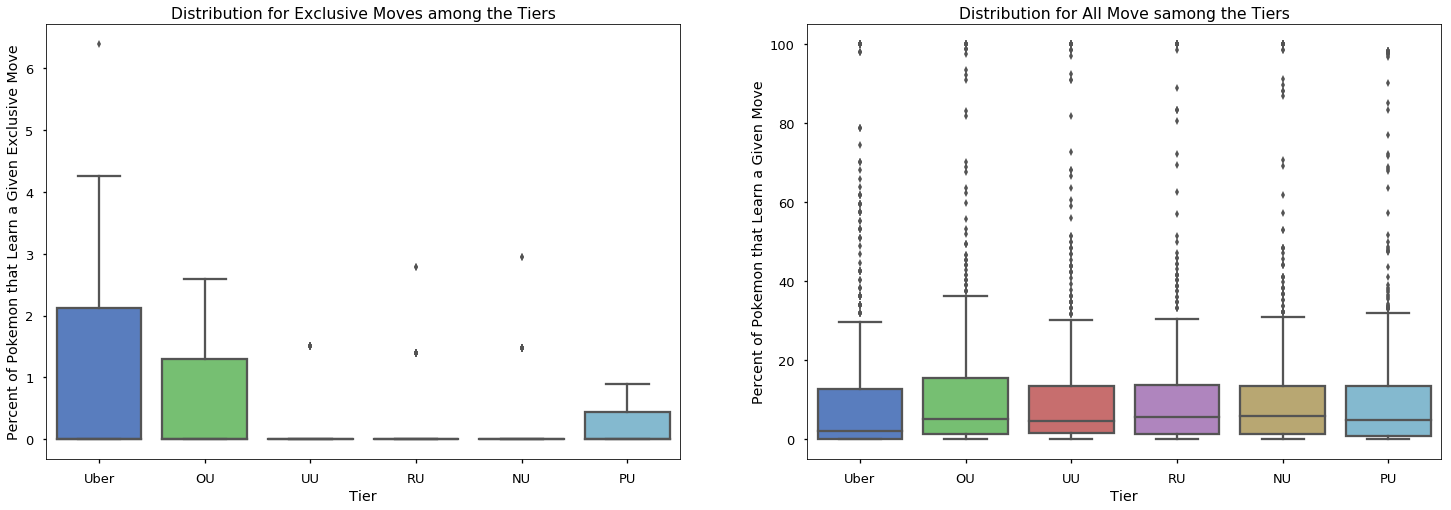

In [33]:
for t in tiers:
    mdf[t + ' %'] = mdf[t.lower() + ' count']/tier_size[t]*100

exclusives = mdf[mdf['count'] <= 3][[t + ' %' for t in tiers]].unstack().reset_index()
del exclusives['name']
exclusives.columns=['Tier', 'Percent of Pokemon that Learn a Given Exclusive Move']
exclusives['Tier'] = exclusives.apply(lambda x: x['Tier'].split(' ')[0], axis=1)

normals = mdf.copy()[[t + ' %' for t in tiers]].unstack().reset_index()
del normals['name']
normals.columns=['Tier', 'Percent of Pokemon that Learn a Given Move']
normals['Tier'] = normals.apply(lambda x: x['Tier'].split(' ')[0], axis=1)

fig, ax = plt.subplots(1,2, figsize=(25,8))
sns.boxplot(data=exclusives, x='Tier', y='Percent of Pokemon that Learn a Given Exclusive Move', palette='muted', ax=ax[0])
sns.boxplot(data=normals, x='Tier', y='Percent of Pokemon that Learn a Given Move', palette='muted', ax=ax[1])
ax[0].set(title='Distribution for Exclusive Moves among the Tiers')
ax[1].set(title='Distribution for All Move samong the Tiers')

For overall moves, as expected, the distributions of pokemon that learn a given move are very similar. Far more pokemon in the Ubers have exclusives than any other tier, which makes sense as many legendaries with exclusive moves belong to this tier (most of the rest of the legendaries are in OU). The PU for exclusive moves can be attributed to some "vanity" exclusvies that are given to weaker pokemon in lower tiers that are not extraordinary in battle.

In summary, this graph says that for a given exclusive move, it's most likely that it will be learned by a pokemon in ubers.

Let's see how typical moves are distrbuted between the tiers in a heatmap.

Text(0.5,0.98,'Percent of Pokemon that Learn each Move by Tier')

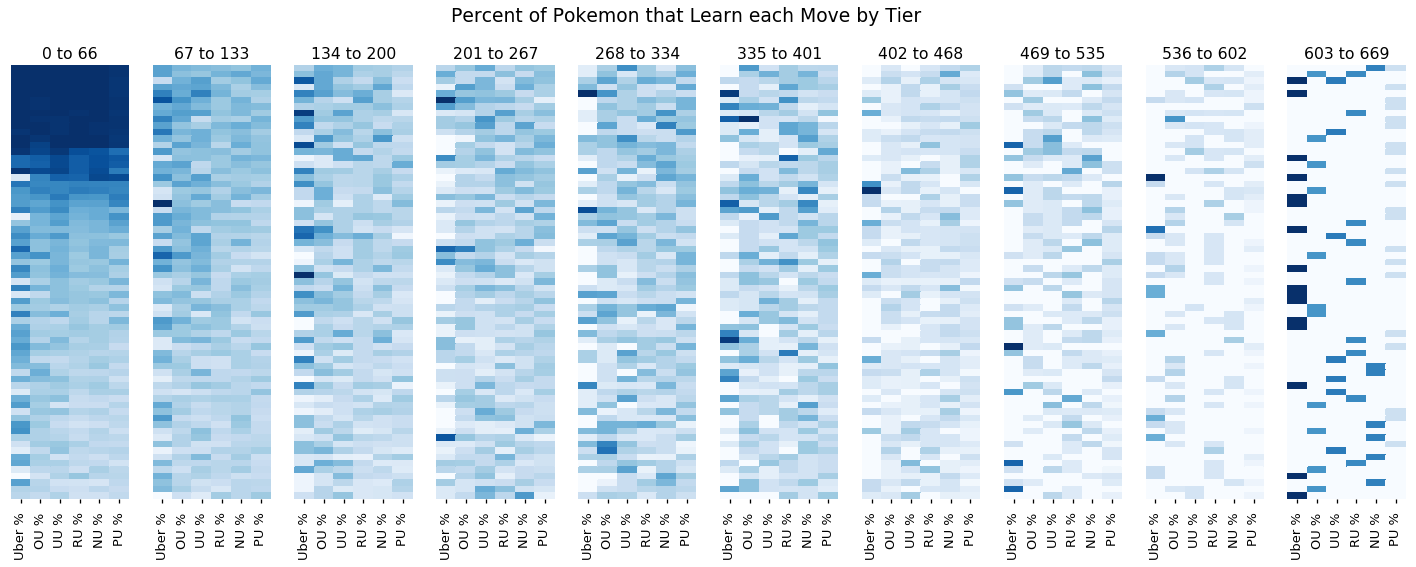

In [34]:
num_plots = 10
fig, ax = plt.subplots(1,num_plots, figsize=(25,8))

heatmap_df = mdf.sort_values('count', ascending=False)[[t + ' %' for t in tiers]]
num_elem = len(heatmap_df)
split_heat_df = []

for i in range(0, num_elem, int(num_elem/num_plots)):
    split_heat_df.append(heatmap_df.iloc[i:i+int(num_elem/num_plots)])

for hdf, axis, i in zip(split_heat_df, ax, range(0, num_elem, int(num_elem/num_plots))):
    sns.heatmap(data=heatmap_df.iloc[i:i+int(num_elem/num_plots)], 
                annot=False, cmap='Blues', ax = axis, cbar=False)
    axis.get_yaxis().set_visible(False)
    axis.set(title="{} to {}".format(i, i+int(num_elem/num_plots)-1))
    
fig.suptitle('Percent of Pokemon that Learn each Move by Tier')

For the top 200 most common moves, the distribution is less even for the Ubers than other tiers, and Ubers has more exclusive moves. Apart from this, there is no obvious pattern that will help us classify pokemon into tiers.

Based on this information, let's create a feature describing the number of "exclusive" moves a pokemon can learn for further analysis. This seems to be the only valuable indicator from the moves.

In [35]:
exclusive_moves = set(mdf[mdf['count'] <= 3].index)
df['num_exclusive'] = df.apply(lambda x: len(exclusive_moves.intersection(x['moves'])), axis=1)

Before, we visualized for a given move, what the expected percentage of pokemon from each tier learn that move. Now, for each tier, let's see what percentage of pokemon have an exclusive move. We will split up the bars based on how many moves exclusive moves they learn.

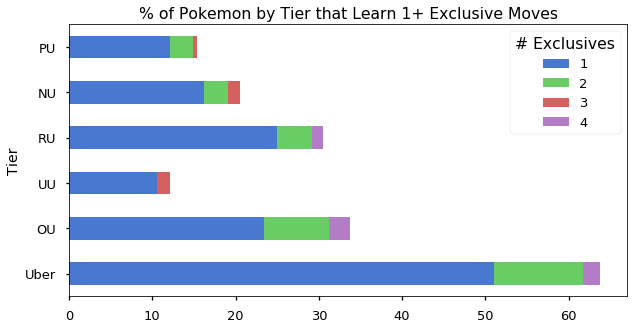

In [36]:
edf = df.loc[:, ['tier', 'tier_num', 'num_exclusive']]
edf['indicator'] = edf.apply(lambda x: 1 if x.num_exclusive > 0 else 0, axis=1)
edf = edf.pivot_table(values='indicator', index=['tier', 'tier_num'], columns='num_exclusive', fill_value=0, aggfunc=np.count_nonzero)
edf.reset_index(inplace=True)
edf.columns = ['Tier', 'tier_num'] + [str(i) for i in range(5)]
edf.sort_values('tier_num', inplace=True)
del edf['tier_num']
del edf['0']

for i in range(1,  5):
    edf[str(i)] = edf.apply(lambda x: x[str(i)]/tier_size[x['Tier']]*100, axis=1)

edf.set_index('Tier').plot.barh(stacked=True, color=sns.color_palette('muted'), figsize=(10, 5))
plt.gca().set(title='% of Pokemon by Tier that Learn 1+ Exclusive Moves')
plt.legend(title='# Exclusives')

Looking forward, our model will have far too many features if we include all the moves for each pokemon. Unfortunately, with the data we have, we cannot easily bin the non-damaging moves. For offensive moves, consider the following logic:

Ignoring negative effects a damaging move may have, you want your pokemon to have the most powerful moves available subject to a few conditions. First, usually, you want the move to have sufficient accuracy. In my experience, this means a move with an accuracy of 85% or above except for special circumstances (e.g. accuracy boosting, weather conditions that boost accuracy). Next, you want to choose a move that compliments your pokemon's attacking stats, typically the higher one. The move's type is also important when considering STAB and coverage (the ability to effectively damage a wide variety of pokemon types). A move's additional effects are also important, but unfortunately, we do not have access to that data.

With this in mind, for each pokemon, let's create 36 features. For each type, we will list the power of the highest damaging special and physical move that has an accuracy >= 85%. Also, we create a feature called primary_attack, which lists the pokemon's strongest STAB move based on it's strongest attacking stat (physical for attack, special for special attack).

In [37]:
highest_moves = []
#we do not want to count moves with recharge as half power,
#as they waste a turn and are not used commonly used in competitive
moves_w_recharge = {'Blast Burn', 'Frenzy Plant', 'Giga Impact', 'Hydro Cannon',
                      'Hyper Beam', 'Prismatic Laster', 'Roar of Time', 'Rock Wrecker',
                      'Shadow Half'}
# a special move that lowers special atk is not that useful,
# similarly a physical move that lowers atk is not that useful
moves_lower_attack = {'Overheat', 'Draco Meteor', 'Leaf Storm', 'Fleur Cannon', 
                      'Psycho Boost', 'Superpower'}
#these moves cause the user to fiant, so they will not be included
self_destroy = {'Explosion', 'Self-Destruct'}

def get_max_power(moves, typ, category, min_acc):
    moves = list(set(moves) - moves_w_recharge - moves_lower_attack - self_destroy)
    highest = np.max([mdf.loc[m, 'power'] if mdf.loc[m, 'category'] == category
                                          and mdf.loc[m, 'accuracy'] >= min_acc 
                                          and mdf.loc[m, 'type'] == typ
                                       else 0
                        for m in moves])
    return highest

def get_primary(x):
    atk_higher = x.atk >= x.spa
    spa_higher = x.spa >= x.atk
    candidates = []
    for t in x.types:
        candidates.append(x[t+'_physical'] if x.atk >= x.spa else 0)
        candidates.append(x[t+'_special'] if x.atk <= x.spa else 0)
    return np.max(candidates)

for t in type_set:
    df[t+'_physical'] = df.apply(lambda x: get_max_power(x.moves, t, 'Physical', 85), axis=1)
    df[t+'_special'] = df.apply(lambda x: get_max_power(x.moves, t, 'Special', 85), axis=1)
    highest_moves += [t+'_physical', t+'_special']

df['primary_attack'] = df.apply(get_primary, axis=1)

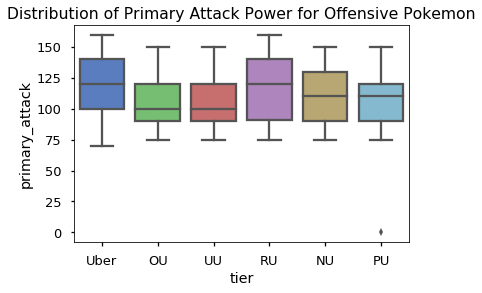

In [38]:
offensive_pokemon = df.apply(lambda x: max(x['atk'], x['spa']) > max(x['def'], x['spd']), axis=1)
a=sns.boxplot(data=df[offensive_pokemon], x='tier', y='primary_attack', palette='muted', order=tiers)
a.set(title='Distribution of Primary Attack Power for Offensive Pokemon')
None

Contrary to our hypothesis, the primary attack feature gives us limited distinction between the tiers, even when we filter for exclusively offensive pokemon. This is likely because pokemon typically have access to strong moves of their own type. So, we will not use this feature when modelling. We will retain information about the power of moves of different types for each pokemon, as this varies a lot.

There are likely common patterns for movepools of pokemon. Let's encode these moves into hot-vectors and see if we can cluster them. We will use K-modes, as this is categorical data.

In [39]:
move_set = set()

for ind, row in df.iterrows():
    move_set |= row.moves

move_df = df[['tier', 'tier_num']]

for m in move_set:
    move_df[m] = df.apply(lambda x: 1 if m in x.moves else 0, axis = 1)

C:\Users\Nick\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [40]:
from kmodes.kmodes import KModes
import pickle

num_clusters = list(range(1, 150))
cost = []
models = []
temp_data = move_df[list(move_set)]

'''
for c in num_clusters:
    km = KModes(n_clusters=c, init='Huang', n_init=5)
    clusters = km.fit(temp_data)
    cost.append(km.cost_)
    models.append(km)
    with open('model' + str(c) + '.pkl', 'wb') as f:
       pickle.dump(km, f)
'''

with open('kmodes-cost.pkl', 'rb') as f:
    cost = pickle.load(f)

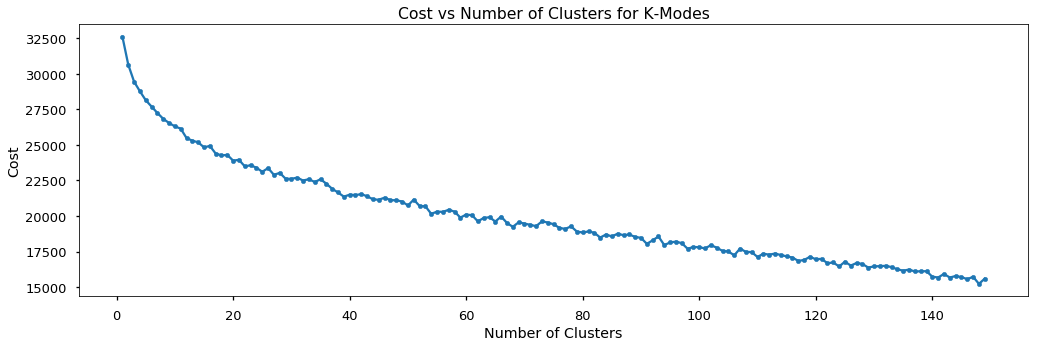

In [41]:
plt.figure(figsize=(17,5))
plt.gca().set(title='Cost vs Number of Clusters for K-Modes', xlabel='Number of Clusters', ylabel='Cost')
plt.scatter(num_clusters, cost, s=20)
plt.plot(num_clusters, cost)

There is no distinct elbow in this curve. Clusters at interesting places, such as 39 and 12, were inspected but the groups did not have seem to have any particular structure or significance. For this reason, we will not use these clusterings for classification.

## Abilities <a class="anchor" id="abilities"></a>

Finally, let's look at abilities. Like moves, there abilities that can make a mediocre pokemon extraordinary, such as Speed Boost on Blaziken. Unlike moves, a great pokemon that has only a bad ability can be ruined, such as Slow Start on Regigigas or Truant on Slaking. For this reason, we will analyze abilities very differently from moves: we shall focus on which abilities have a significant impact on a Pokemon's tier level.

Let's first create a dataframe with the abilities and look at their occurences in each tier.

In [42]:
from collections import defaultdict
a_dict = defaultdict(int)

for ind, row in df.iterrows():
    for ability in row.abilities:
        a_dict[(ability, row.tier + ' count')] += 1


adf = pd.DataFrame(pd.Series(a_dict)).reset_index() #(columns=(['name'] + [t + ' Count' for t in tiers]))
adf.columns=['name', 'tier', 'count']
adf = adf.pivot_table(values='count', index='name', columns='tier', fill_value=-0)
adf['count'] = sum(adf[t + ' count'] for t in tiers)

[Text(0.5,1,'Frequencies of Abilities by the Number of Pokemon that have Them')]

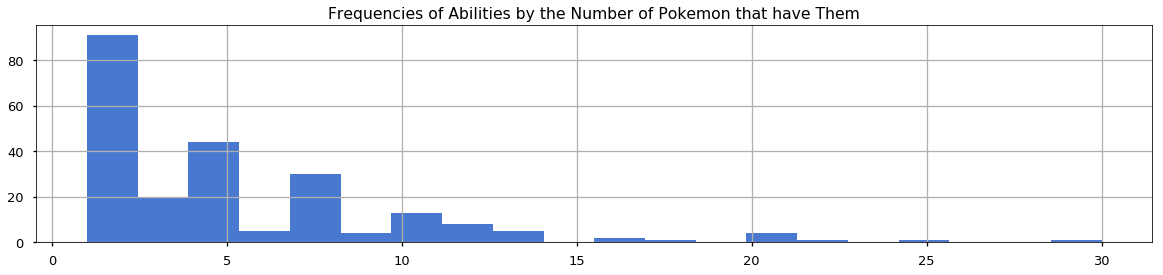

In [43]:
plt.figure(figsize=(20, 4))
adf['count'].hist(bins=20, color=sns.color_palette('muted')[0])
plt.gca().set(title='Frequencies of Abilities by the Number of Pokemon that have Them')

As with the moves, relatively unique abilities are the most common. This makes sense: a lot of legendaries and other pokemon have their own abilities. Unlike moves, pokemon can have at most 3 abilities. Exclusive moves are therefore quite common, and so it would not make sense to investigate exclusive abilities.

Typically, abilities have a positive or neutral effect. Bulbapedia supplies a list of abilities with negative effects; however, many of these abilities are not necessarily negative. For example, Contrary reverses stack changes inflicted on the pokemon. This is extremely advantageous (and is often leveraged) when using powerful moves that, as a side effect, lower the pokemon's stats. 

After reading through the list, the following abilities are truly negative in battle: Comatose, Defeatist, Emergency Exit, Slow Start, Stall, Truant, Wimp Out. Let's look at how many pokemon actually have these abilities as their only option(s) (as otherwise, they could choose a beneficial ability):

In [44]:
bad_abilities = {'Comatose', 'Defeatist', 'Emergency Exit', 'Slow Start', 'Truant', 'Wimp Out', 'Stall'}
df['bad_ability'] = df.apply(lambda x: 1 if len(set(x['abilities']).intersection(bad_abilities)) == len(x['abilities'])
                                       else 0, axis=1)
df[df.bad_ability == 1]

,types,abilities,tier,hp,atk,def,spa,spd,spe,next_evos,...,Poison_physical,Poison_special,Fire_physical,Fire_special,Electric_physical,Electric_special,Normal_physical,Normal_special,primary_attack,bad_ability
name,,,,,,,,,,,,,,,,,,,,,
Archeops,"[Rock, Flying]",[Defeatist],NU,75,140,65,112,65,110,[],...,0.0,0.0,0.0,95.0,0.0,0.0,120.0,90.0,140.0,1
Golisopod,"[Bug, Water]",[Emergency Exit],RU,75,125,140,60,90,40,[],...,80.0,95.0,0.0,0.0,0.0,0.0,70.0,60.0,90.0,1
Komala,[Normal],[Comatose],PU,65,115,65,75,95,65,[],...,0.0,0.0,0.0,0.0,0.0,0.0,120.0,60.0,120.0,1
Regigigas,[Normal],[Slow Start],PU,110,160,110,80,110,100,[],...,0.0,0.0,75.0,0.0,75.0,90.0,90.0,60.0,90.0,1
Slaking,[Normal],[Truant],PU,150,160,100,95,65,100,[],...,120.0,0.0,75.0,110.0,75.0,90.0,120.0,90.0,120.0,1


Upon inspection, it is likely these Pokemon would be in higher tiers without their respective abilities. Regigigas and Slaking have massive base stat totals with large movepools and neutral typing: a formula to be in UU at least. Archeops's typing and stats would find use in RU. It is hard to say if Golisopod and Komala would be elsewhere. To some extent, this new feature is a useful indicator.

## Evolutionary Stage <a class="anchor" id="stage"></a>

When processing the data, we created a feature describing a pokemon's evolutionary stage. Let's see if this actually correlates with a pokemon's tier.

<Figure size 1440x288 with 0 Axes>

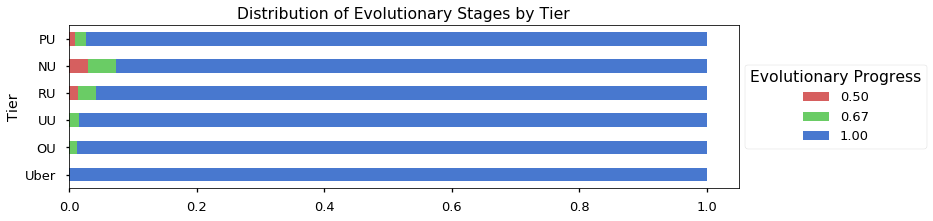

In [45]:
evodf = df.loc[:, ['tier', 'tier_num', 'evo_progress']]
evodf['count'] = evodf.apply(lambda x: 1/tier_size[x.tier], axis=1) 
#so when we sum everything up, values will be normalized to tier size
evodf = evodf.pivot_table(values='count', index=['tier', 'tier_num'], columns='evo_progress', fill_value=0, aggfunc=np.sum)
evodf = evodf.sort_values('tier_num').reset_index()
del evodf['tier_num']
evodf.columns = ['Tier', '0.50', '0.67', '1.00']
evodf.set_index('Tier', inplace=True)

plt.figure(figsize=(20, 4))
evodf.plot.barh(stacked=True, color=sns.color_palette('muted')[2::-1], figsize=(12, 3), 
                title='Distribution of Evolutionary Stages by Tier')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),title='Evolutionary Progress')

Pokemon that are 0.33 of the way through their evolutionary process are typically in the LC (Little Cup) tier, or are otherwise too weak to use in the main tiers. As expected, higher tiers are mostly composed of fully evolved pokemon. Partially evolved pokemon are still viable due to unique abilities or items, such as Eviolite which only works on unevolved pokemon. Interestingly, it seems like NU has more unevolved pokemon than PU. But recall, PU is a far larger tier than the rest, so it is also full of pokemon that don't evolve at all but are quite weak.

Let's also look at the average distance between a pokemon and it's evolution in terms of tier. Note that all the unevolved pokemon in competitive tiers have only one more evolution.

The next evolution of unevolved pokemon are on average 2.19±1.42 tiers above.


Text(0,0.5,'Frequency')

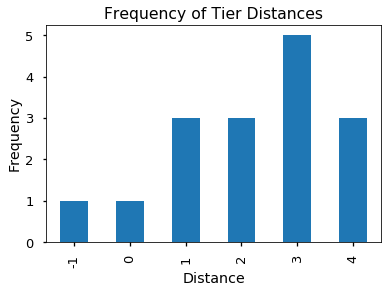

In [46]:
distdf = df.loc[df['evo_progress'] < 1, ['tier', 'tier_num','next_evos']] #'evo progress',
distdf['dist'] = distdf.apply(lambda x: x.tier_num - np.max(df.loc[x.next_evos, 'tier_num']), axis=1)
print('The next evolution of unevolved pokemon are on average {:.2f}±{:.2f} tiers above.'
      .format(np.mean(distdf['dist']), np.std(distdf['dist'])))

freqdf = distdf.reset_index()
freqdf = freqdf[['dist', 'tier']].groupby('dist').count().reset_index()#.sort_values('tier_num
freqdf.columns = ['Distance', 'Count']
freqdf.set_index('Distance').plot.bar(title='Frequency of Tier Distances', legend=None)
plt.ylabel('Frequency')

On average, the evolved form of an unevolved pokemon in the competitive tiers is 2 tiers above it. Interestingly, Chansey is in a higher tier than its evolution: Blissey. This is due to eviolite: an item that significantly increases the defenses of unevolved pokemon. Both Chansey and Blissey serve as specially defensive walls, but Chansey plays this role better with the eviolite than Blissey does otherwise.

## Alternate Forms <a class="anchor" id="forms"></a>

Like above, let's look at the distribution of normal, mega, and alternate forms in each tier. 

<Figure size 1440x288 with 0 Axes>

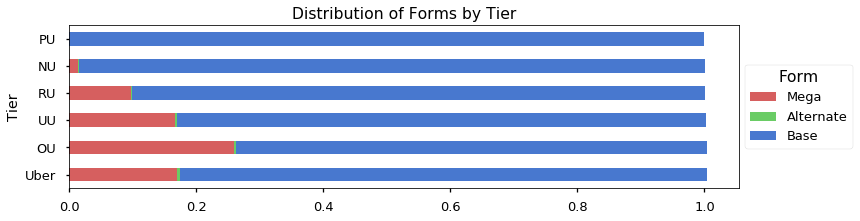

In [47]:
altdf = df.loc[:, ['tier', 'tier_num', 'mega', 'alt_form']]
altdf['mega'] = altdf.apply(lambda x: x.mega/tier_size[x.tier], axis=1) 
altdf['alt_form'] = altdf.apply(lambda x: x.mega/tier_size[x.tier], axis=1)
altdf['normal'] = altdf.apply(lambda x: 1/tier_size[x.tier] if x['mega'] == 0 and x['alt_form'] == 0 else 0, axis=1)
#so when we sum everything up, values will be normalized to tier size

#altdf = altdf.pivot_table(values='count', index=['tier', 'tier_num'], columns='evo progress', fill_value=0, aggfunc=np.sum)
altdf = altdf.groupby(['tier', 'tier_num']).agg(np.sum).reset_index().sort_values('tier_num')
del altdf['tier_num']
altdf.columns = ['Tier', 'Mega', 'Alternate', 'Base']
altdf.set_index('Tier', inplace=True)

plt.figure(figsize=(20, 4))
altdf.plot.barh(stacked=True, color=sns.color_palette('muted')[2::-1], figsize=(12, 3), 
                title='Distribution of Forms by Tier')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),title='Form')

As expected, higher tiers generally have more alternate/mega forms. There are very few pokemon with alternate forms; most of the ones that do are legendaries, so it makes sense that the Uber tier has the most alternate forms. Interestingly, OU has the most Mega evolutions, which makes sense because primarily non-legendary pokemon receive mega evolutions, and few mega-evolutions are extraordinary in the competitive scene (though they often outclass their base forms).

Similar to evolutions, let's look at the average distance between a pokemon and its alternate form. Since one Pokemon can have multiple alternate forms, we will instead look at the average tier of base pokemon with alternate forms vs the average tier of the alternate forms of those base pokemon.

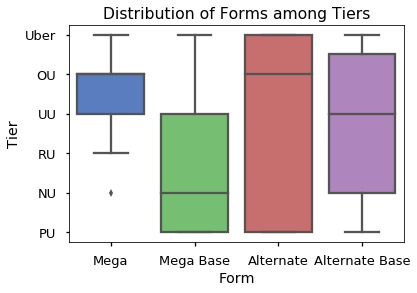

In [48]:
alt = df.loc[(df['alt_form'] == 1), ['tier_num']]
mega = df.loc[(df['mega'] == 1), ['tier_num']]
alt_base = df.loc[set(map(lambda x: x.split('-')[0], alt.index)), ['tier_num']]
mega_base = df.loc[set(map(lambda x: x.split('-')[0], mega.index)), ['tier_num']]

alt['Form'] = 'Alternate'
mega['Form'] = 'Mega'
alt_base['Form'] = 'Alternate Base'
mega_base['Form'] = 'Mega Base'

combined = pd.concat([mega, mega_base, alt, alt_base])
combined.columns = ['Tier', 'Form']
plt.gca().invert_yaxis()
plt.gca().set(title='Distribution of Forms among Tiers', yticklabels=['']+tiers)
sns.boxplot(data=combined, x='Form', y='Tier', palette='muted')

As expected, mega evolutions are well above their base counterparts (the median is at OU). Alternate forms tend to be higher than their base forms (based on the median), but difference is not as defined. Interestingly, all the forms but mega are represented in all the tiers. These results make sense, as mega evolutions were designed to be direct upgrades to their counterparts, while alternate forms are often exactly their namesakes: alternates.

## Anomaly Analysis <a class="anchor" id="anomaly"></a>

Intuitively, a pokemon's offensive and defensive stats should be strong indicators of what tier they will be in; however, analysis above revealed that there is much uncertainty in averages by tier and so it is not a reliable indicator. Let's investigate some outliers in each tier to get an idea of what causes this uncertainty. We will consider pokemon whose base stat totals are outside of 2 standard deviations of their tier's mean.

In [49]:
bstdf = df[['tier', 'bst']].groupby('tier').agg([np.mean, np.std])
bstdf.columns = ['bst_mean', 'bst_std']
df2 = df.reset_index().merge(bstdf, left_on='tier', right_on='tier')

under = df2[(df2['bst'] < df2['bst_mean'] - 2*df2['bst_std']) & (df2['tier'] != 'PU')]
over = df2[(df2['bst'] > df2['bst_mean'] + 2*df2['bst_std']) & (df2['tier'] != 'Uber')]

under[['tier', 'name', 'types', 'abilities', 'hp', 'atk', 'def', 'spa', 'spd', 'spe', 'bst', 'bst_mean', 'evo_progress', 'num_moves', 'num_exclusive']]

,tier,name,types,abilities,hp,atk,def,spa,spd,spe,bst,bst_mean,evo_progress,num_moves,num_exclusive
262,RU,Linoone,[Normal],"[Gluttony, Pickup, Quick Feet]",78,70,61,50,61,100,420,524.486111,1.0,89,0
330,UU,Marowak-Alola,"[Fire, Ghost]","[Cursed Body, Lightning Rod, Rock Head]",60,80,110,50,80,45,425,538.181818,1.0,74,3
394,NU,Medicham,"[Fighting, Psychic]","[Pure Power, Telepathy]",60,60,75,60,75,80,410,495.132353,1.0,96,0
425,NU,Vivillon,"[Bug, Flying]","[Compound Eyes, Friend Guard, Shield Dust]",80,52,50,90,50,89,411,495.132353,1.0,59,1
428,Uber,Aegislash,"[Steel, Ghost]",[Stance Change],60,50,150,50,150,60,520,657.042553,1.0,55,1
429,Uber,Aegislash-Blade,"[Steel, Ghost]",[Stance Change],60,150,50,150,50,60,520,657.042553,1.0,55,1
478,OU,Azumarill,"[Water, Fairy]","[Huge Power, Sap Sipper, Thick Fat]",100,50,80,60,80,50,420,565.896104,1.0,96,0
489,OU,Diggersby,"[Normal, Ground]","[Cheek Pouch, Huge Power, Pickup]",85,56,77,50,77,78,423,565.896104,1.0,81,0


Listed above are pokemon who's stats appear to be too weak for their tier. Upon further research, here are the reasons why they are in their respective tiers (all quotes are from Smogon, a strategy guide).

**Linoone**: "Linoone has unique access to Belly Drum and Extreme Speed, making up for its mediocre Attack stat and allowing it to OHKO [one hit knock out] most of the tier after a Belly Drum." Belly Drum increases a pokemon's attack by +6 (a 3x multiplier) and Extreme Speed is a strong has +2 priority (which makes it move before other moves regardless of speed). Linoone also has receives a Same Type Attack Bonus (STAB, which is 1.5x) on the 80 base power (BP) Extreme Speed. Clearly, a potent combination.

**Marowak-Alola**: "Alolan Marowak's offensive typing in conjunction with Thick Club gives it a strong niche on Trick Room teams as a wallbreaker." Thick club is an item that doubles only Marowak/Cubone's attack.

**Medicham**: The ability Pure Power double's Medicham's attack which, combined with its good typing, makes it powerful in its tier.

**Vivilion**: "The combination of its access to Quiver Dance, decent Speed and Special Attack, and good offensive typing makes Vivillon one of the deadliest setup sweepers in NU"

**Aegislash / Aegislash-Blade**: Overall, it's unique stat distribution, strong defensive typing, useful moves and unique ability make it a great counter to many pokemon in Ubers.

**Azumarill**: "Azumarill is a decent sweeper in the OU metagame with the combination of Belly Drum, Aqua Jet, and its ability Huge Power." Similar to Linoone's Extreme Speed, Aqua Jet is a STAB priority move. Huge Power has the same effect as Pure Power (double's the pokemon's attack).

**Diggersby**: "Diggersby is one of the best physical wallbreakers in the metagame thanks to Huge Power along with its access to great STAB attacks, coverage in Fire Punch, and priority in Quick Attack."

#### Summary
Pokemon with weak stats in higher tiers almost always have an ability or set-up move that significantly boosts their offensive stats, along with a move or two to support it. 

In [50]:
over[['tier', 'name', 'types', 'abilities', 'hp', 'atk', 'def', 'spa', 'spd', 'spe', 'bst', 'bst_mean', 'evo_progress', 'num_moves', 'num_exclusive', 'bad_ability']]

,tier,name,types,abilities,hp,atk,def,spa,spd,spe,bst,bst_mean,evo_progress,num_moves,num_exclusive,bad_ability
159,PU,Regigigas,[Normal],[Slow Start],110,160,110,80,110,100,670,464.184685,1.0,69,1,1
179,PU,Slaking,[Normal],[Truant],150,160,100,95,65,100,670,464.184685,1.0,100,0,1
215,PU,Wishiwashi-School,[Water],[Schooling],45,140,130,140,135,30,620,464.184685,1.0,43,0,0
229,RU,Blastoise-Mega,[Water],[Mega Launcher],79,103,120,135,115,78,630,524.486111,1.0,108,0,0
324,UU,Kyurem,"[Dragon, Ice]",[Pressure],125,130,90,130,90,95,660,538.181818,1.0,64,1,0
375,NU,Diancie,"[Rock, Fairy]",[Clear Body],50,100,150,100,150,50,600,495.132353,1.0,61,1,0
383,NU,Guzzlord,"[Dark, Dragon]",[Beast Boost],223,101,53,97,53,43,570,495.132353,1.0,53,0,0
419,NU,Uxie,[Psychic],[Levitate],75,75,130,75,130,95,580,495.132353,1.0,78,0,0


Listed above are pokemon who's stats appear to be too strong for their tier. Once again, from Smogon:

**Regigigas / Slaking**: Both have ridiculously high stats, but are crippled by their abilities. Slow Start halves the pokemon's attack and speed for the first five turns. Truant prevents the pokemon from attacking every other term.

**Wishiwashi-School**: This pokemon is also crippled by it's ability. Its HP is already quite low, but once that drops below 1/4, it reverts to its solo form, which has a pitiful BST of 175.

**Blastoise-Mega**: This case is quite interesting. It has great stats, a decent ability, and access to useful moves like Rapid Spinner. It seems like it could play the role of a defensive Bulky-Water. However, it has two flaws: lack of access to a recovery move (which a pokemon in such a role would need) and there are simply better options.

**Kyurem**: Another very powerful pokemon that simply has stronger alternatives: its alternate forms. Also, despite it's strong offensive stats, its speed and access to a spammable ice moves make it less than ideal for Ubers.

**Diancie**: Unique typing, and high defenses makes it seem like a strong pokemon. However, low HP renders it's defenses nearly useless. Also, it's outshone by its mega evolution (who is in OU).

**Guzzlord**: It has great typing and seems to be a defensive tank, however, it's low defenses really let down its massive HP. Furthermore, its seemingly great typing is unfortunately weak to many common attacking type. 

**Uxie**: Strange stat distribution. High defenses without decent HP is not very useful (especially with mediocre defensive typing). 

#### Summary
High stats with a strange distribution is not helpful or with a detrimental ability will force a pokemon into a low tier.

#### Take Away
Based on Blastoise, access to recovery is an important aspect of a defensive pokemon. Otherwise, all the information we need to determine if a pokemon with high stats would end up in a lower tier is already contained in the data we have. Pokemon in high tiers with low stats, however, seem to benefit greatly from stat increasing moves, abilities, and STAB priority moves. Let's create features for these. 

First, reliable stat increasing moves. We will only consider moves that increase a stat (or multiply) by more than one stage. We will ignore evasion increasing moves, as these are illegal in competitive play. Let's also ignore moves that increase only the defenses, as we have not seen evidence that these are particularly beneficial. We will also quantify the net increase each move provides.

In [51]:
#defenses only: {'Acid Armor': 2, 'Barrier': 2,' Cotton Guard': 3, 'Iron Defense': 2, 'Stockpile': 2, 'Amnesia': 2
stat_increasing = {'Coil': 3, 'Hone Claws': 2, 'Belly Drum': 6, 'Bulk Up': 2, 'Clangorous Soulblaze': 4, 
                   'Dragon Dance': 2, 'Shell Smash': 4, 'Shift Gear': 3, 'Swords Dance': 2, 'Work Up': 2,
                   'Cosmic Power': 2,  'Defend Order': 2, 'Calm Mind': 2, 'Geomancy': 6, 
                   'Nasty Plot': 2, 'Quiver Dance': 3, 'Tail Glow': 3, 'Agility': 2, 'Automize': 2, 'Rock Polish': 2}


df['stat_inc_move'] = df.apply(lambda x: np.max([0]+[stat_increasing[v] for v in x.moves.intersection(stat_increasing)]), axis=1)

Now, boosting abilities. Most abilities require the pokemon to satisfy some sort of condition before boosting their stats, but the two abilities we saw above boost the pokemon's offensive stats unconditionally. Let's create a feature for abilities like these (which happens to be just those two):

In [52]:
atk_inc_ability = {'Huge Power', 'Pure Power'}
df['atk_inc_ability'] = df.apply(lambda x: 1 if len(set(x.abilities).intersection({'Huge Power', 'Pure Power'})) > 0 else 0, axis=1)

Next, reliable recovery moves. We will consider moves that immediately heal without side effects to be reliable.

In [53]:
recovery = {'Heal Order', 'Milk Drink', 'Moonlight', 'Morning Sun', 'Purify', 'Recover',
            'Roost', 'Shore Up', 'Slack Off', 'Soft-Boiled', 'Synthesis', 'Strength Sap', 'Wish'}
df['recovery_move'] = df.apply(lambda x: 1 if len(x.moves.intersection(recovery)) > 0 else 0, axis=1)

Finally, STAB priority moves. We will not consider Quick Attack, as it is so common and not useful in competitive play (due to power and type). One important consideration are the moves Fake Out, Extreme Speed, and Sucker Punch. Without going into detail, generally, the limitations of these moves balance their advantages, so we will consider them equally for simplicity.

In [54]:
priority = {'Fake Out', 'Extreme Speed', 'Feint', 'Aqua Jet', 'Bullet Punch', 'Ice Shard', 'Accelerock'
            'Mach Punch', 'Shadow Sneak', 'Sucker Punch', 'Vacuum Wave', 'Water Shuriken'}
df['priority_stab'] = df.apply(lambda x: 1 if any([(mdf.loc[m, 'type'] in x.types) 
                                                   for m in x.moves.intersection(priority)]) else 0,
                               axis=1)

## Modelling <a class="anchor" id="modelling"></a>

### Feature Space Reduction <a class="anchor" id="feature-reduce"></a>

Before we encode the categorical variables, we should make another effort to reduce the high dimensional  ability data. In pokemon, some abilities have near-identical counterparts with different names. We will consolidate these. This information is from Bulbapedia.

In [55]:
#To do this efficiently, we will simply create a dictionary of moves and abilities.
#We will map all of them to themselves to start, then alter the variations
ability_set = set()
move_set = set()
type_set = set()

for ind, row in df.iterrows():
    ability_set |=  set(row.abilities) #union
    move_set |= row.moves
    type_set |= set(row.types)

ability_dict = {s:{s} for s in ability_set if s not in {
                   'Battle Armor', 'White Smoke', 'Full Metal Body', 'Solid Rock', 'Prism Armor', 'Gooey', 
                   'Magnet Pull', 'Shadow Tag', 'Inner Focus', 'Insomnia', 'Vital Spirit', 'Limber', 'Magma Armor', 
                  'Own Tempo', 'Oblivious', 'Water Veil', 'Sweet Veil', 'Aroma Veil', 'Hyper Cutter', 'Big Pecks',
                   'Triage', 'Heatproof', 'Iron Barbs', 'Quick Feet', 'Flare Boost', 'Toxic Boost'
               }} #dictionary of sets

#We will not consolidate weather-variations because the viability of various weather conditions varies

ability_dict['Shell Armor'].add('Battle Armor')
ability_dict['Clear Body'] |= {'White Smoke', 'Full Metal Body'}
ability_dict['Filter'] |= {'Solid Rock', 'Prism Armor'}
ability_dict['Tangling Hair'].add('Gooey')

# Below are cases where the abilities aren't identical, but close enough
ability_dict['Arena Trap'] |= {'Magnet Pull', 'Shadow Tag'} 
ability_dict['Guts'] |= {'Quick Feet', 'Flare Boost', 'Toxic Boost'} # Marvel scale is excluded from this because it boosts defense
ability_dict['Immunity'] |= {'Inner Focus', 'Insomnia', 'Vital Spirit', 'Limber', 'Magma Armor', 
          'Own Tempo', 'Oblivious', 'Water Veil', 'Sweet Veil', 'Aroma Veil'}
ability_dict['Keen Eye'] |= {'Hyper Cutter', 'Big Pecks'} 
ability_dict['Prankster'].add('Triage')
ability_dict['Thick Fat'].add('Heatproof')
ability_dict['Rough Skin'].add('Iron Barbs')
#water absorb and dry skin?

In the anomaly analysis section, we made features based on groups of moves. We can continue to do so based on my experience playing competitive as well as articles from Smogon.

In [56]:
entry_hazards = {'Toxic Spikes', 'Stealth Rock', 'Spikes'}
df['entry_hazards'] = df.apply(lambda x: 1 if len(x.moves.intersection(entry_hazards)) > 0 else 0, axis=1)

hazard_clear = {'Rapid Spin'} #we may later exclude/add defog 
df['hazard_clear'] = df.apply(lambda x: 1 if len(x.moves.intersection(hazard_clear)) > 0 else 0, axis=1)

phazing_moves = {'Roar', 'Whirlwind', 'Dragon Tail', 'Circle Throw'}
df['phazing_moves'] = df.apply(lambda x: 1 if len(x.moves.intersection(phazing_moves)) > 0 else 0, axis=1)

switch_attack = {'U-turn', 'Volt Switch'}
df['switch_attack'] = df.apply(lambda x: 1 if len(x.moves.intersection(switch_attack)) > 0 else 0, axis=1)

#strong moves (>65 power) that have a >30% chance of causing side effects with an accuracy over 85%
high_side_fx_prob = {'Steam Eruption','Sludge Bomb', 'Lava Plume', 'Iron Tail', 'Searing Shot', 
                     'Rolling Kick', 'Rock Slide', 'Poison Jab', 'Muddy Water', 'Iron Head',
                    'Icicle Crash', 'Headbutt', 'Gunk Shot', 'Discharge', 'Body Slam', 'Air Slash'}
df['high_side_fx_prob'] = df.apply(lambda x: 1 if len(x.moves.intersection(high_side_fx_prob)) > 0 else 0, axis=1)

constant_dmg = {'Seismic Toss', 'Night Shade'}
df['constant_dmg'] = df.apply(lambda x: 1 if len(x.moves.intersection(constant_dmg)) > 0 else 0, axis=1)

trapping_move = {'Mean Look', 'Block', 'Spider Web'}
df['trapping_move'] = df.apply(lambda x: 1 if len(x.moves.intersection(trapping_move)) > 0 else 0, axis=1)

### Encoding Data <a class="anchor" id="encoding"></a>

Let's create x and y dataframes.

In [57]:
stats = ['hp', 'atk', 'def', 'spa', 'spd', 'spe'] #bst excluded
forms = ['evo_progress', 'mega', 'alt_form']
moves_based = ['num_moves','num_exclusive', 'bad_ability', 'stat_inc_move', 'recovery_move', 'priority_stab',
              'entry_hazards', 'hazard_clear', 'phazing_moves', 'switch_attack', 'high_side_fx_prob', 'constant_dmg',
              'trapping_move']
ability_based = ['atk_inc_ability', 'bad_ability']

df_y = df.loc[:, 'tier_num']
df_x = df.loc[:, stats + forms + moves_based + ability_based + highest_moves] 
#remove bst because it is just a sum of the individual stats

Next, we want to encode the categorical variables: types, abilities, and moves. We created features for some abilities and moves, so we will remove those from the encoding. Let's also remove exclusive moves and abilities, as we training/testing with moves/abilities with few samples will yield more noise than benefit.

In [58]:
ability_set -= atk_inc_ability | bad_abilities | set(adf[adf['count'] <= 2].index)
move_set -=  stat_increasing.keys() | recovery | priority | set(mdf[(mdf['count'] <= 3) | (mdf['power'] > 0)].index) \
             | entry_hazards | hazard_clear | phazing_moves | switch_attack | high_side_fx_prob | constant_dmg | trapping_move

for a in ability_dict.keys():
    df_x[a] = df.apply(lambda x: 1 if len(ability_dict[a].intersection(x.abilities))>0 else 0, axis = 1)
for m in move_set:
    df_x[m] = df.apply(lambda x: 1 if m in x.moves else 0, axis = 1)
for t in type_set:
    df_x[t] = df.apply(lambda x: 1 if t in x.types else 0, axis = 1)

C:\Users\Nick\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


We have been working on reducing the number of features for regression by consolidating features (we currently have 492 features). However, we have a lot of features where only 1 or 2 pokemon have that feature. Let's count the number of non-zero entries for each feature. Features that are very sparse will likely add more noise than regression power, so we will remove these.

In [59]:
counts = df_x.astype(bool).sum(axis=0)
#let's exclude our engineered features and let the model decide if those are important
counts.drop(stats + forms + moves_based + ability_based + highest_moves, inplace=True)
cutoff = list(range(1, 30))
num_vars = [len(df_x.drop(counts[counts<=c].index.values, axis=1).columns) for c in cutoff]

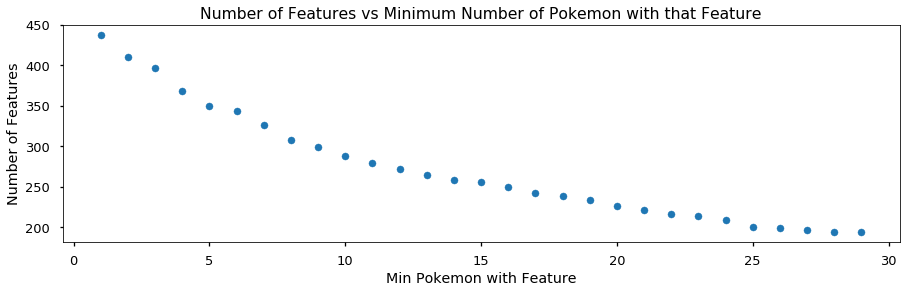

In [60]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.set(title='Number of Features vs Minimum Number of Pokemon with that Feature', 
       xlabel='Min Pokemon with Feature',ylabel='Number of Features')
ax.scatter(cutoff, num_vars, s=50)
None

For now, let's use a cutoff of at least 8 pokemon with a feature, bringing out feature count under 400.

In [61]:
df_x.drop(counts[counts<=7].index.values, axis=1, inplace=True)
len(df_x.columns)

326

### Exploratory Modelling/ Feature Selection <a class="anchor" id="em"></a>

Before selecting features using lasso, let's use a normal Linear Regression to determine if the response (mostly) linear. We will examine the residual and studentized residual plots.

C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\distributions.py:645: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


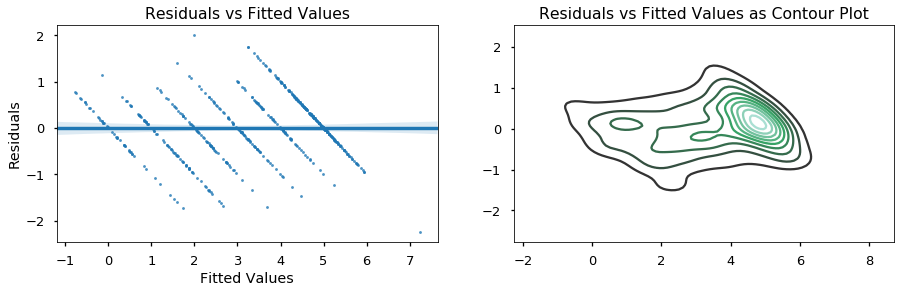

In [62]:
import statsmodels.api as sm

temp_df_x = df_x.copy()
temp_df_x['Intercept'] = np.ones((len(temp_df_x),))
ols_model = sm.OLS(df_y, temp_df_x).fit()

def fitted_to_tier(num):
    if num < 0: return 0
    elif num > 5: return 5
    else: return num

results = df_y.to_frame()
results['Fitted Values'] = ols_model.predict(temp_df_x)
results['Modified Fitted Values'] = results['Fitted Values'].map(fitted_to_tier)
results['Residuals'] = df_y.values - ols_model.predict(temp_df_x)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].set(title='Residuals vs Fitted Values')
ax[1].set(title='Residuals vs Fitted Values as Contour Plot')
sns.regplot(data=results, x='Fitted Values', y='Residuals', ax=ax[0], scatter_kws={'s':8})
sns.kdeplot(data=results[['Fitted Values', 'Residuals']], ax=ax[1])

We modified the fitted values because values above or below the tier range will be placed in the nearest respective tier (PU or Uber). The residuals have a mean of zero, but do not seem to be normally distributed at all. Let's check:

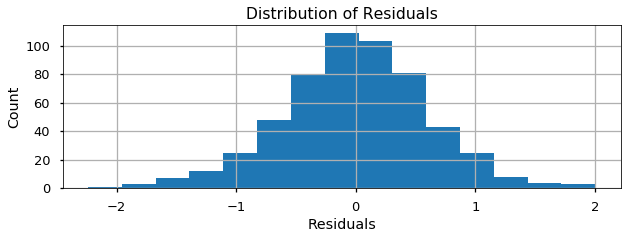

In [63]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.set(title='Distribution of Residuals', ylabel='Count', xlabel='Residuals')
results['Residuals'].hist(ax=ax, bins=15)

Clearly, our residuals are practically normally distributed, but a bit left skewed. We can still use Lasso to identify some useful features.

C:\Users\Nick\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:323: RuntimeWarning: invalid value encountered in sqrt
  return  self.results.resid / sigma / np.sqrt(1 - hii)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\Nick\Anaconda3\lib\site-packages\statsmodels\stats\multitest.py:147: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals <= alphacBonf
C:\Users\Nick\Anaconda3\lib\site-packages\statsmodels\stats\multitest.py:251: RuntimeWarning: invalid value encountered in g

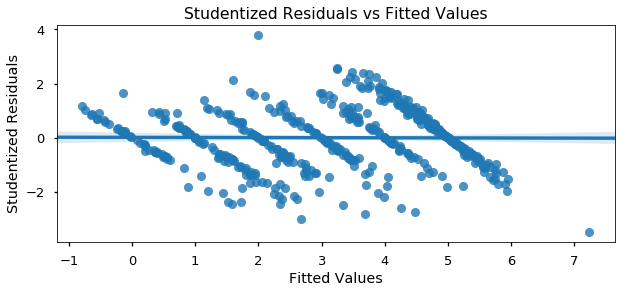

In [64]:
results['Studentized Residuals'] = ols_model.outlier_test().student_resid
fig, ax = plt.subplots(figsize=(10, 4))
ax.set(title='Studentized Residuals vs Fitted Values')
sns.regplot(data=results, x='Fitted Values', y='Studentized Residuals', ax=ax)

The Studentized Residuals clearly show some outlier points. Let's investigate these.

In [65]:
results[abs(results['Studentized Residuals']) >= 3]

,tier_num,Fitted Values,Modified Fitted Values,Residuals,Studentized Residuals
name,,,,,
Claydol,4,1.995662,1.995662,2.004338,3.806903
Wishiwashi,5,7.239385,5.000000,-2.239385,-3.498476


Technically, the model correctly identified Wishiwashi as a PU pokemon (as a rating of 7 would be rounded down to 5, putting it into PU). 

According to Smogon, for Claydol, "Don't use this Pokemon unless your team really can't afford to run separate Stealth Rock and entry hazard control options; its semi-unique ability to run both Stealth Rock and Rapid Spin simultaneously is the only reason you should really consider using it." We already have features that cover Stealth Rock and Rapid Spin. Hopefully a better model will be able to discern this.

Let's use Lasso to see if our notions about important features were correct. I wrote bootstrapping code to compute confidence intervals, but this is not particularly helpful considering the current sizes of our feature set vs dataset.

We must keep in mind that this will not help us select features. By nature, the tiering system relies on complex interaction between the features that we have. The lasso model we will use is additive, and therefore, does not model interactions by default.

In [66]:
from sklearn import linear_model
from sklearn import feature_selection
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample 

In [67]:
alphas, rmse, num_sig = np.arange(0.0001, 0.1, 0.0001), [], []

for a in alphas:
    reg = linear_model.Lasso(alpha=a, normalize=True, max_iter=10000)
    '''
    temp_rmse, temp_sig = [], []
    for i in range(500):
        temp_x, temp_y = resample(df_x, df_y, n_samples=400)
        reg.fit(temp_x, temp_y)
        temp_rmse.append(np.sqrt(mean_squared_error(df_y, reg.predict(df_x))))
        temp_sig.append(reg.coef_)
    
    temp_sig = zip(*temp_sig) #flips
    temp_sig2 = [(np.mean(coef), np.std(coef)) for coef in temp_sig]
    
    rmse.append(np.mean(temp_rmse))
    num_sig.append(np.sum([1 for c in temp_sig2 if abs(c[0]) >= c[1] and abs(c[0]) > 0.0001]))
    '''
    reg.fit(df_x, df_y)
    rmse.append(np.sqrt(mean_squared_error(df_y, reg.predict(df_x))))
    num_sig.append(sum([1 for c in reg.coef_ if abs(c) > 0.0001]))
    #not c[0]-2*c[1] <= 0 <= c[0]+2*c[1]

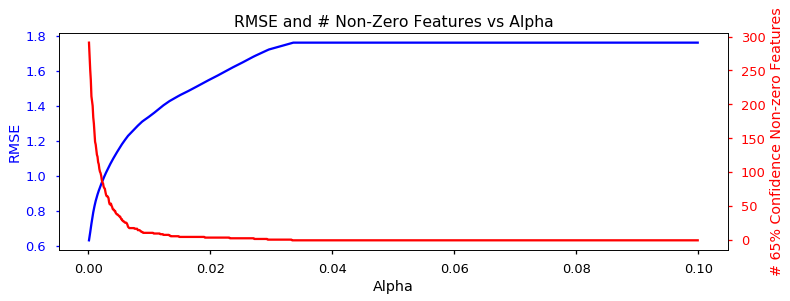

In [68]:
def easy_dual_plot(x, y1, y2, figsize=(12, 4), title='', xlabel='', ylabel1='', ylabel2=''):
    fig, ax = plt.subplots(figsize=figsize) #2, 1, 
    ax.set(title=title)
    ax.plot(x, y1, color='b')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel1, color='b')
    ax.tick_params('y', colors='b')

    ax2 = ax.twinx()
    ax2.plot(x, y2, color='r')
    ax2.set_ylabel(ylabel2, color='Red')
    ax2.tick_params('y', colors='r')

easy_dual_plot(alphas, rmse, num_sig, title='RMSE and # Non-Zero Features vs Alpha',
               xlabel='Alpha', ylabel1='RMSE', ylabel2='# 65% Confidence Non-zero Features')

In [69]:
reg = linear_model.Lasso(alpha=0.003, normalize=True, max_iter=100000)
reg.fit(df_x, df_y)
'''
temp_sig=[]
for i in range(1000):
    temp_x, temp_y = resample(df_x, df_y, n_samples=400)
    reg.fit(temp_x, temp_y)
    temp_rmse.append(np.sqrt(mean_squared_error(df_y, reg.predict(df_x))))
    temp_sig.append(reg.coef_)
    
temp_sig = zip(*temp_sig) #flips
reg_coef = [np.mean(coef) for coef in temp_sig]
std = [np.std(coef) for coef in temp_sig]
'''


'\ntemp_sig=[]\nfor i in range(1000):\n    temp_x, temp_y = resample(df_x, df_y, n_samples=400)\n    reg.fit(temp_x, temp_y)\n    temp_rmse.append(np.sqrt(mean_squared_error(df_y, reg.predict(df_x))))\n    temp_sig.append(reg.coef_)\n    \ntemp_sig = zip(*temp_sig) #flips\nreg_coef = [np.mean(coef) for coef in temp_sig]\nstd = [np.std(coef) for coef in temp_sig]\n'

In [98]:
coef = sorted([(prop, c) for c, prop in zip(reg.coef_, df_x.columns)], key=(lambda x: -abs(x[1])))
coef = list(filter(lambda x: abs(x[1]) > 0.0001, coef))
print('{} non-zero features'.format(sum([1 for c in coef if abs(c[1]) > 0.0001])))
print()
print("{0:<18} {1:>6}".format('Feature', 'Coeff')) #{2:>10} , 'Std'
print('-'*26)
for c in coef:
    #print("{0:<18} {1:>6.3f} {2:>10.3f} {3}".format(*c, ('  65% Confident' if abs(c[1]) > 2*abs(c[2]) else '')))
    print("{0:<18} {1:>6.3f}".format(*c)) #{2:>10.3f}

29 non-zero features

Feature             Coeff
--------------------------
Regenerator        -1.087
atk_inc_ability    -1.003
bad_ability         0.864
mega               -0.606
Beast Boost        -0.402
Clear Body          0.354
Frisk               0.335
Chlorophyll         0.201
entry_hazards      -0.194
num_exclusive      -0.089
Dragon              0.071
Keen Eye            0.056
Swift Swim          0.050
Levitate            0.037
priority_stab      -0.032
Immunity            0.021
Hydration           0.018
bad_ability         0.016
spe                -0.015
spa                -0.011
hp                 -0.010
atk                -0.010
spd                -0.008
def                -0.006
Dragon_special     -0.002
Flying_physical    -0.002
Poison_physical    -0.001
Steel_physical     -0.001
Bug_special         0.001


Most of the coefficients are in line with what we expected, with no notable exceptions. However, we cannot necessarily use this information as is to further select features, as all these predictors heavily interact with eachother.

Let's tackle this regression problem with a model that inherently accounts for interaction: a Decision Tree.

In [71]:
import sklearn.ensemble as ens
import sklearn.tree as tree
from sklearn.model_selection import cross_val_score

model = tree.DecisionTreeRegressor(max_depth=15, max_leaf_nodes = 30)
model.fit(df_x, df_y)

train_rmse = np.mean(np.sqrt(mean_squared_error(df_y, model.predict(df_x))))
cv_rmse = np.mean(np.sqrt(-cross_val_score(model, df_x, df_y, cv=10, scoring='neg_mean_squared_error')))
print('Train Error: {}'.format(train_rmse))
print('CV Error:    {}'.format(cv_rmse))

Train Error: 0.9014597566112288
CV Error:    1.4660709763338684


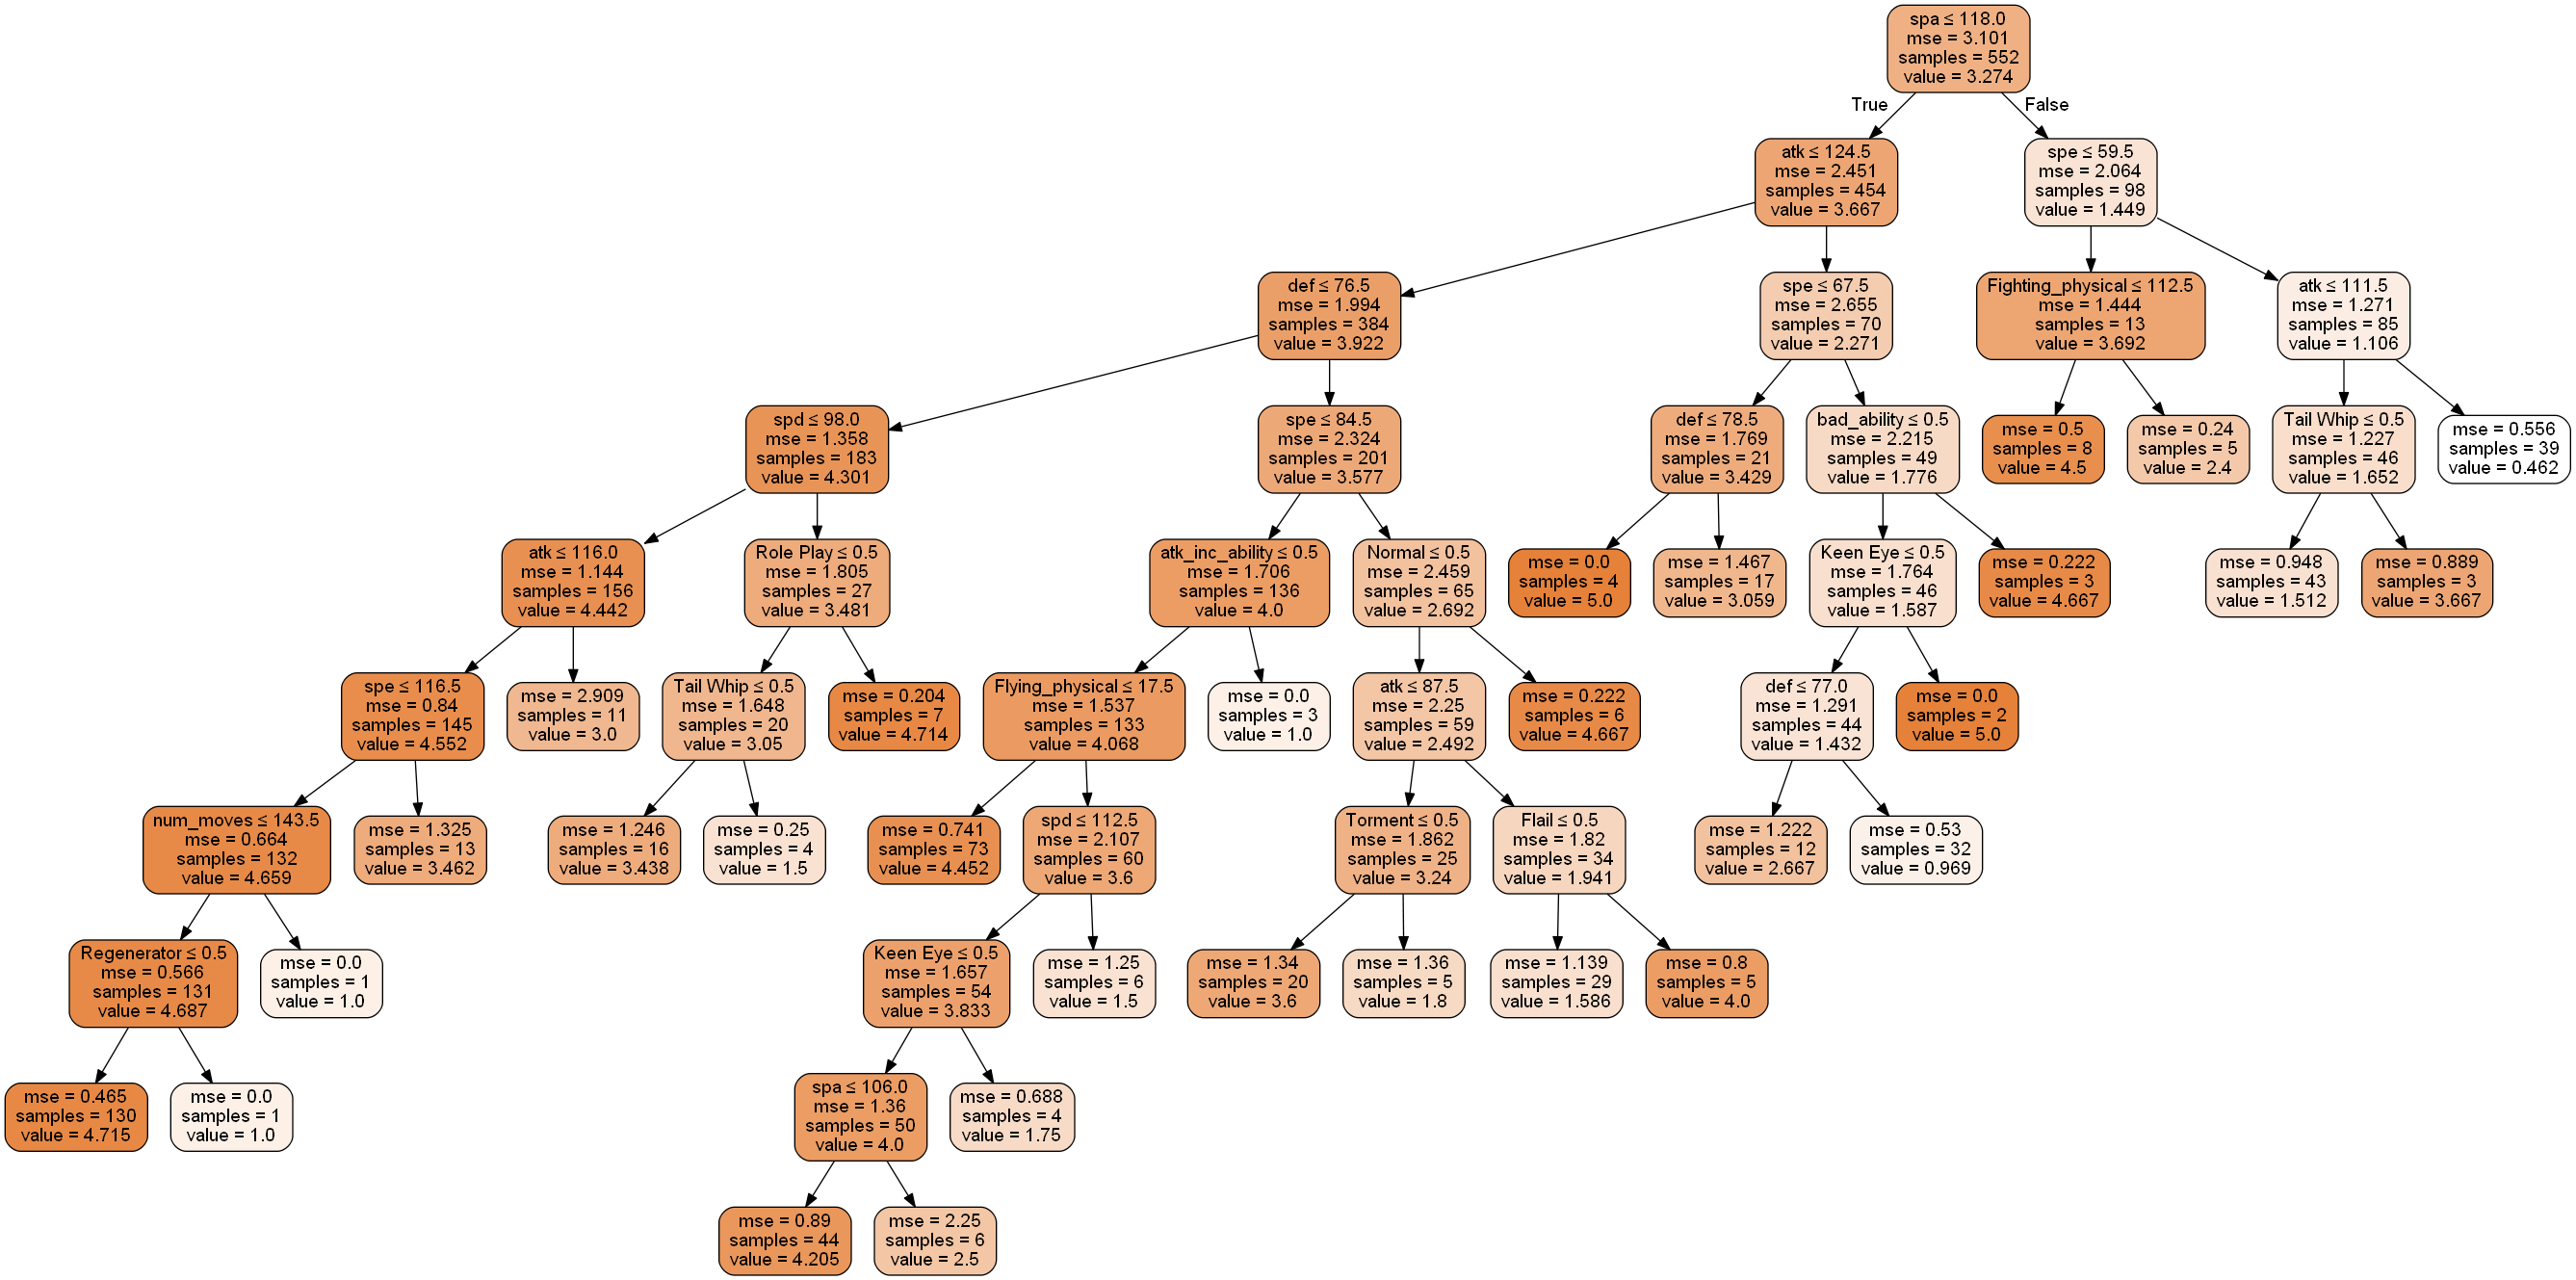

In [72]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
g = tree.export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=df_x.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

This classifier is not very good, but it has given us much insight about the features. Our generated features seem to help this decision tree split samples. 

Our goal is to create a model that, in a sense, understand what makes a pokemon stronger or weaker. After iterating through several versions of this decision tree, I noticed that the tree split based on a move that is not used at all in competitive. This means the model is overfitting (which we knew) and just capturing noise in the data. Let's remove all the move indicators altogether.

In [73]:
df_x.drop(list(move_set.intersection(set(df_x.columns))), axis=1, inplace=True)

model2 = tree.DecisionTreeRegressor(max_depth=10, max_leaf_nodes = 20)
model2.fit(df_x, df_y)

train_rmse = np.mean(np.sqrt(mean_squared_error(df_y, model2.predict(df_x))))
cv_rmse = np.mean(np.sqrt(-cross_val_score(model2, df_x, df_y, cv=10, scoring='neg_mean_squared_error')))
print('Train Error: {}'.format(train_rmse))
print('CV Error:    {}'.format(cv_rmse))

Train Error: 1.0348716894900738
CV Error:    1.4712730068356676


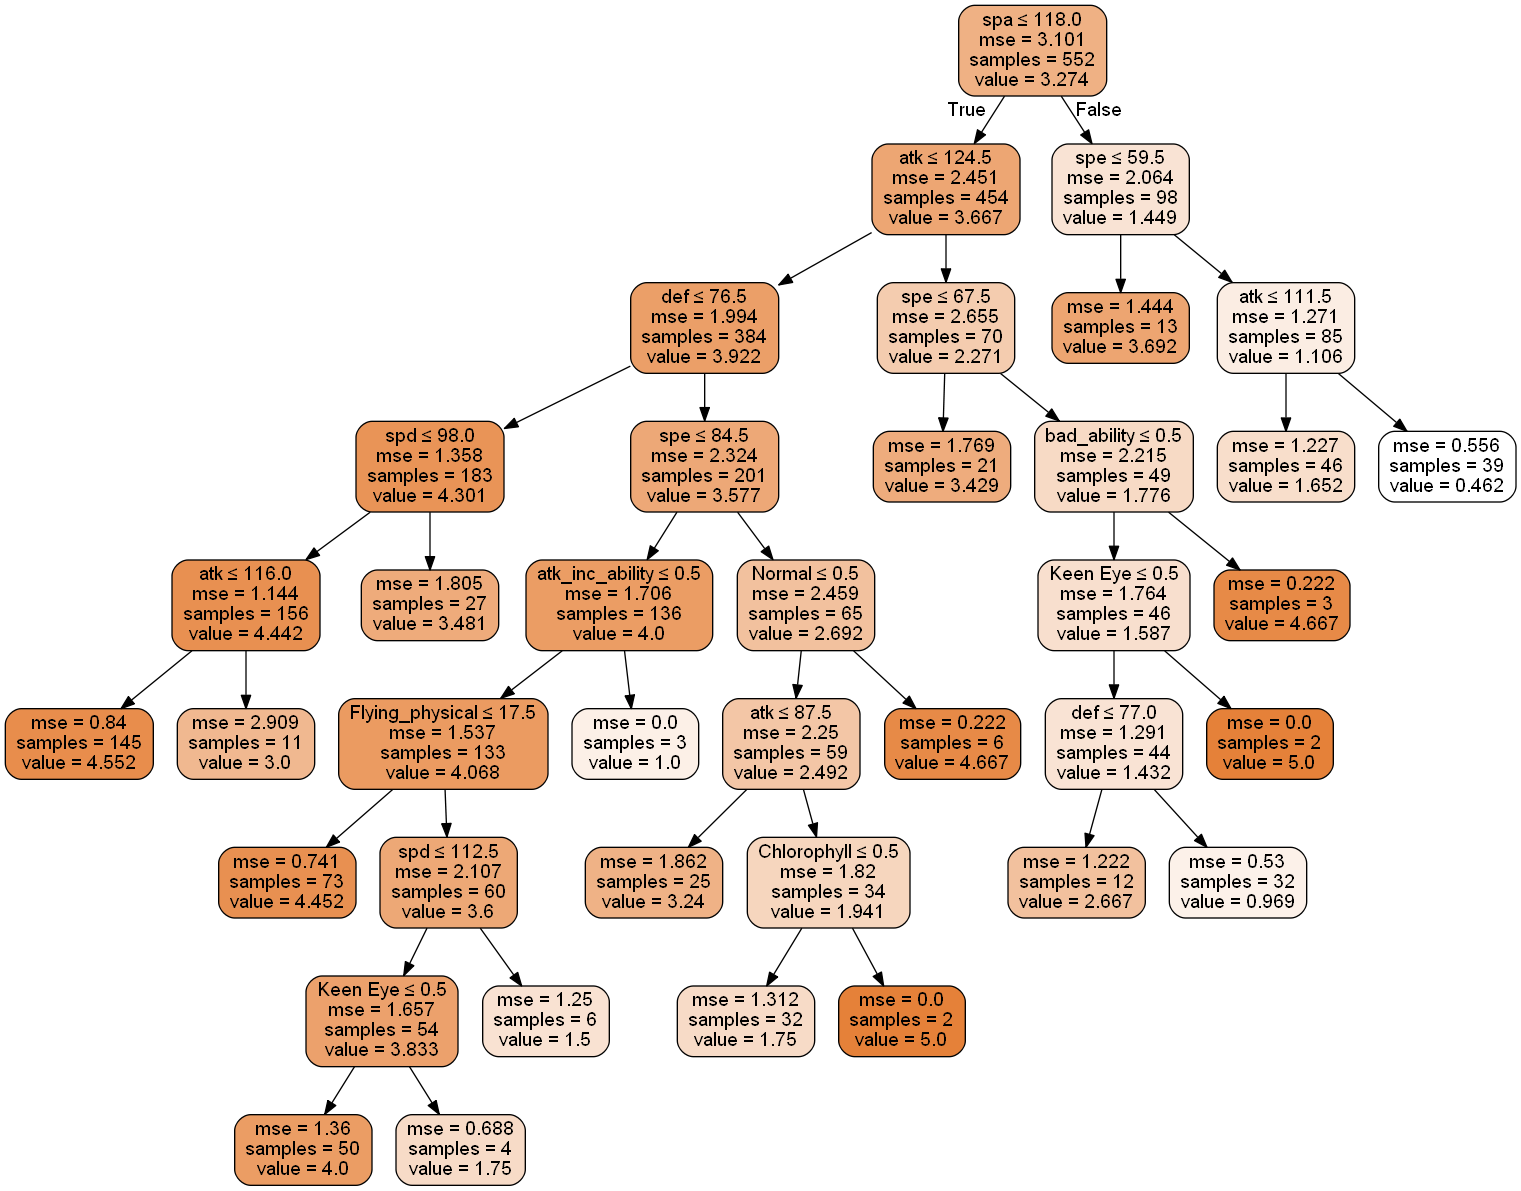

In [74]:
dot_data = StringIO()
g = tree.export_graphviz(model2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=df_x.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Model Selection <a class="anchor" id="model-selection"></a>

Based on our classification task (ordinal classification, which we will achieve through regression), data size, and data characteristics, a tree-based model appears to be the best approach. We will try both a Random Forest and Gradient Boosting.

Notice we are evaluating training error on the whole dataset, then evaluating cross validation using sklearn's cross validation function. This function trains the model again with a subset of the data then tests with a seperate set. Also, note that we are using mean absolute error as our training criteria, as this is a ordinal classification task, not a true regression task.

In [75]:
model3 = ens.RandomForestRegressor(n_estimators=15, criterion='mae', max_depth=50, max_features='auto')
model3.fit(df_x, df_y)

train_rmse = np.mean(np.sqrt(mean_squared_error(df_y, model3.predict(df_x))))
cv_rmse = np.mean(np.sqrt(-cross_val_score(model3, df_x, df_y, cv=10, scoring='neg_mean_squared_error')))
print('Train Error: {}'.format(train_rmse))
print('CV Error:    {}'.format(cv_rmse))

Train Error: 0.5102176606034198
CV Error:    1.2383629247373868


In [76]:
model4 = ens.GradientBoostingRegressor(loss='ls')
#interestingly, least squares worked better than least absolute deviance
model4.fit(df_x, df_y)

train_rmse = np.mean(np.sqrt(mean_squared_error(df_y, model4.predict(df_x))))
cv_rmse = np.mean(np.sqrt(-cross_val_score(model4, df_x, df_y, cv=10, scoring='neg_mean_squared_error')))
print('Train Error: {}'.format(train_rmse))
print('CV Error:    {}'.format(cv_rmse))

Train Error: 0.6239962734187703
CV Error:    1.1239074468444994


The results are interesting. Typically, a Random Forest results in lower variance but higher bias, and gradient boosting the opposite. Here, the results are flipped. This is likely due to the lack of parameter tuning.

For our problem, in my view, Gradient Boosting makes the most sense. The data set is too small and sparse for random forest to work effectively. In theory, the average of each tree should make a good decision, but this data lends to each tree learning completely different things that will cancel eachother out. Gradient boosting, on the other hand, is a technique that learns more "slowly" and will hopefully better identify the complex relationships between the features.

### Model Tuning <a class="anchor" id="model-tuning"></a>

In [77]:
final_model = ens.GradientBoostingRegressor(loss='ls', criterion='mae')
#interestingly, least squares worked better than least absolute deviance
final_model.fit(df_x, df_y)
np.sqrt(mean_squared_error(df_y, final_model.predict(df_x)))

train_rmse = np.mean(np.sqrt(mean_squared_error(df_y, model4.predict(df_x))))
cv_rmse = np.mean(np.sqrt(-cross_val_score(model4, df_x, df_y, cv=10, scoring='neg_mean_squared_error')))
print('Train Error: {}'.format(train_rmse))
print('CV Error:    {}'.format(cv_rmse))

Train Error: 0.6239962734187703
CV Error:    1.1300814934249204


Let's use a naive approach to determine the optimal learning rate and max_depth.

In [78]:
max_depth_range = list(range(1, 10))
train_errors, cv_errors = [],[]

for d in max_depth_range:
    final_model = ens.GradientBoostingRegressor(loss='ls', criterion='mae', max_depth = d)
    final_model.fit(df_x, df_y)
    train_errors.append(np.mean(np.sqrt(mean_squared_error(df_y, model4.predict(df_x)))))
    cv_errors.append(np.mean(np.sqrt(-cross_val_score(model4, df_x, df_y, cv=10, scoring='neg_mean_squared_error'))))

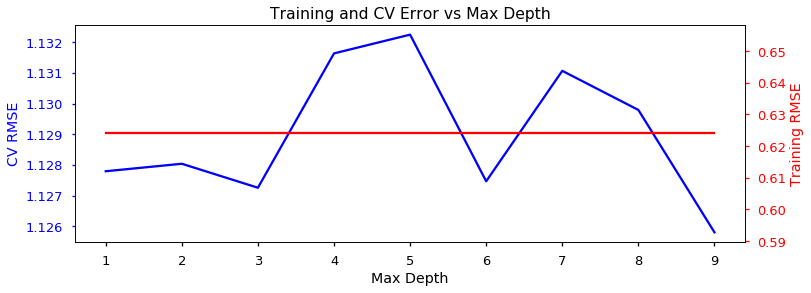

In [79]:
easy_dual_plot(max_depth_range, cv_errors, train_errors, title='Training and CV Error vs Max Depth',
               xlabel='Max Depth', ylabel1='CV RMSE', ylabel2='Training RMSE')

Though the graph is quite inconsistent, a max-depth of 4-5 generally seems to work best. Now, learning rate.

In [80]:
learning_rate = np.arange(0.05, 0.5, 0.05)
train_errors, cv_errors = [],[]

for l in learning_rate:
    final_model = ens.GradientBoostingRegressor(loss='ls', criterion='mae', max_depth = 5, learning_rate=l)
    final_model.fit(df_x, df_y)
    train_errors.append(np.mean(np.sqrt(mean_squared_error(df_y, model4.predict(df_x)))))
    cv_errors.append(np.mean(np.sqrt(-cross_val_score(model4, df_x, df_y, cv=10, scoring='neg_mean_squared_error'))))

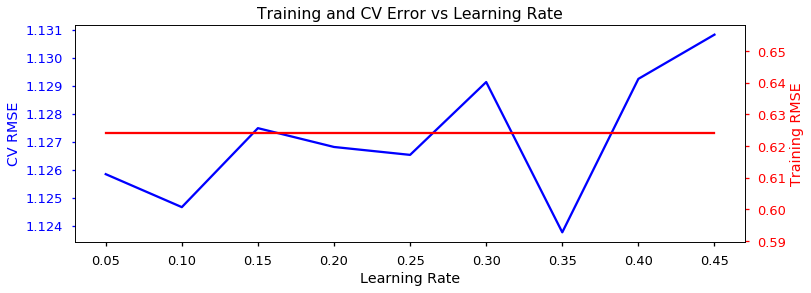

In [81]:
easy_dual_plot(learning_rate, cv_errors, train_errors, title='Training and CV Error vs Learning Rate',
               xlabel='Learning Rate', ylabel1='CV RMSE', ylabel2='Training RMSE')

A few runs revealed the learning rate does not consistently improve or worsen our model, so we will leave it at the default. Let's look into what properties our model found important

In [82]:
final_model = ens.GradientBoostingRegressor(loss='ls', criterion='mae', max_depth=5)
final_model.fit(df_x, df_y)

train_rmse = np.mean(np.sqrt(mean_squared_error(df_y, model4.predict(df_x))))
cv_rmse = np.mean(np.sqrt(-cross_val_score(model4, df_x, df_y, cv=10, scoring='neg_mean_squared_error')))
print('Train Error: {}'.format(train_rmse))
print('CV Error:    {}'.format(cv_rmse))

Train Error: 0.6239962734187703
CV Error:    1.127790884676413


In [106]:
importances = final_model.feature_importances_[:25]
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(25):
    print("{}. feature {} ({})".format(f + 1, df_x.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature spe (0.11144678743368497)
2. feature spa (0.0891450335060182)
3. feature atk (0.07422843441873249)
4. feature hp (0.07189786370992197)
5. feature def (0.06121571873575195)
6. feature num_moves (0.05314594600145165)
7. feature spd (0.04215349527724633)
8. feature atk_inc_ability (0.011296568828122284)
9. feature priority_stab (0.010684394365908567)
10. feature num_exclusive (0.010332792546830692)
11. feature mega (0.007156604727634512)
12. feature Ghost_physical (0.007061167417696221)
13. feature hazard_clear (0.005571849478571791)
14. feature high_side_fx_prob (0.00400756726610178)
15. feature evo_progress (0.0038539653376808325)
16. feature stat_inc_move (0.0035743050825852328)
17. feature bad_ability (0.00336063618978694)
18. feature bad_ability (0.0029541830091143117)
19. feature alt_form (0.0029141456843301476)
20. feature phazing_moves (0.0026467922483715484)
21. feature trapping_move (0.0022081237348602436)
22. feature switch_attack (0.0015621767645356

These features are in line with what we expect; however, there is evidence of overfitting. In particular, this model chose Snow Cloak as a good discriminator, even though there is no empirical evidence supporting this.

Let's look at pokemon that our model is misclassifying from the training set itself:

In [84]:
df['prediction'] = final_model.predict(df_x)
df['rounded_prediction'] = round(df['prediction'])
df['residuals'] = df['tier_num'] - df['prediction']

In [104]:
df.loc[df['rounded_prediction'] != df['tier_num'],
       ['tier', 'tier_num', 'prediction', 'rounded_prediction', 'residuals']].sample(20)

,tier,tier_num,prediction,rounded_prediction,residuals
name,,,,,
Swampert,UU,2,2.639340,3.0,-0.639340
Barbaracle,RU,3,4.306894,4.0,-1.306894
Golbat,NU,4,4.612588,5.0,-0.612588
Hoopa,RU,3,2.439182,2.0,0.560818
Manaphy,OU,1,1.607754,2.0,-0.607754
Tapu Koko,OU,1,1.511145,2.0,-0.511145
Kabutops,PU,5,4.498447,4.0,0.501553
Rampardos,PU,5,4.478435,4.0,0.521565
Leafeon,PU,5,4.257863,4.0,0.742137


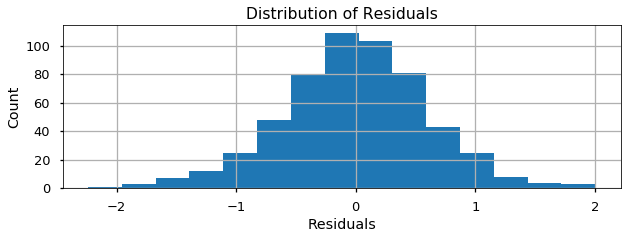

In [86]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.set(title='Distribution of Residuals', ylabel='Count', xlabel='Residuals')
results['Residuals'].hist(ax=ax, bins=15)

These misclassifications are quite insightful. The pokemon who have been misclassified by a lot have very specific niches in the metagame. For example, Mimikyu is in OU SOLELY due to it's ability, Disguise. Similarly, Venomoth's only redeeming feature is its access to Quiver Dance.

Many pokemon were misclassified by a small margin. Many of these, including Mesprit, Shaymin, and others, actually used to be in the tier that the classifier predicted (but have moved down due to useage).

## Summary and Conclusion <a class="anchor" id="conclusion"></a>

In this analysis, we deep-dived into various attributes of pokemon and how they contribute to a pokemon's viability in the competitive metagame. 

We found that stats were a very strong indicator, as expected, but cannot be used for classification alone. We discovered that most moves and abilities were learned by very few pokemon. This made using interesting moves and abilities for classification quite difficult, as there were not enough training examples for the model to learn about the feature.

Other indicators were also found to be useful but inconclusive. Pokemon who are not fully evolved tend to be in lower tiers, while alternate forms and mega evolutions tend to be in higher tiers, as expected. Various types were found to be more common in upper tiers and others in lower tiers.

The most interesting results came from analyzing pokemon outside of two standard deviations of the BST average for their tier. We engineered several useful features, including a bad ability indicator, stat increasing move indicator, and stat increasing ability indicator. 

We did some further feature consolidation by combining like moves in our model selection. We also used a Lasso to identify what features were useful and which were not. Ultimately, we decided to drop all moves we did not consolidate from our featureset. After some model selection, we chose a Gradient Boosting Regression Tree, due to it's ability to learn complex relationships to reduce the bias in our model.

In the end, this model performed mediocrely, but this was expected. Competitive pokemon tiers are based on human behaviour, and pokemon tiers change all the time (in fact, halfway through this analysis, Claydol was promoted to NU!). We found that Pokemon our model severely misclassified often carved their niche in the tiers they are in. These complex combinations of abilities, moves, stats, and typing were difficult for our model to learn about, due to the limited volume and type of data. Some of the Pokemon our model slightly misclassified actually used to be in the tiers our model predicted!

Going forward, it would be useful to analyze move-by-move battle data to gain more insight about how players actually use these Pokemon. It would be an interesting task to build a model that is able to understand the relationships between pokemon on a team to build a team that has synergy. A step beyond that would be to build a model to actually battle with its team.